# Simulations analysis 

In [18]:
import sys
sys.path.append("../wrf_hydro_pyscripts/")
from helper_functions import restartkernel

restartkernel()

Important: if you wish to use dill.dump() to save the workspace, the autoreload should not be loaded

In [19]:
%load_ext autoreload
%autoreload 2

In [20]:
import datetime
now = datetime.datetime.now()
print(str(now))

sim_path = '/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small10/'
print('Dir = ' + sim_path)

2020-01-16 14:04:30.513507
Dir = /Volumes/0543970348/IE_directory/simulation/synthetic_lior/small10/


In [21]:
sim_path

'/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small10/'

In [22]:
include_matlab_files = False

In [23]:
%matplotlib inline

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import os.path
import glob
# from os import listdir
from pyproj import Proj, transform
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import curve_fit
import matplotlib.transforms as mtransforms
import matplotlib.gridspec as gridspec

import sys
# the equivalent to "Add to path" in Matlab
sys.path.append("/Users/adameshel/Documents/Python_scripts/wrf_hydro_pyscripts/") 
from helper_functions import matlab2datetime as matlab2datetime_fancy_import
from helper_functions import split_at

from os.path import isfile, join

import sys
sys.path.append("../my_fuctions/") # the equivalent to "Add to path" in Matlab

from iterative_IDW_V1 import *
# from iterative_IDW import * # Old code (Daniel's)
from geoFunc import *
import kriging as krg
from analysis_funcs import *

## Amending simulation ground truth data

In [25]:
num_of_link_iter = len(glob.glob(sim_path + 'sim_out_*_000_Z.csv'))
num_of_ts = len(sorted(glob.glob(sim_path + 'sim_out_000_*_Z.csv')))
files = sorted(glob.glob(sim_path + 'sim_out_*_Z.csv'))
files

['/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small10/sim_out_000_000_Z.csv',
 '/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small10/sim_out_000_001_Z.csv',
 '/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small10/sim_out_000_002_Z.csv',
 '/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small10/sim_out_000_003_Z.csv',
 '/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small10/sim_out_000_004_Z.csv',
 '/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small10/sim_out_000_005_Z.csv',
 '/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small10/sim_out_000_006_Z.csv',
 '/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small10/sim_out_000_007_Z.csv',
 '/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small10/sim_out_000_008_Z.csv',
 '/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small10/sim_out_000_009_Z.csv']

In [26]:
# all_my_files = sorted(glob.glob(sim_path + 'sim_out_*.csv'))


In [27]:
# # Pythono3 code to rename multiple  
# # files in a directory or folder 
  
# # importing os module 
# import os 
  
# # Function to rename multiple files 
# def main(): 
#     i = 0
      
#     for filename in os.listdir(sim_path):
#         if ('sim_out_' in filename) and ('.csv' in filename):
# #             import pdb; pdb.set_trace()
#             suffix = split_at(filename,'_',-1)[-1]
#             dst ="sim_out_" + '000_00' + suffix
#             src = sim_path + filename 
# #         dst ='xyz'+ dst 
          
#         # rename() function will 
#         # rename all the files 
#             os.rename(src, dst) 
# #         i += 1
# main()

In [28]:
num_of_link_iter = len(glob.glob(sim_path + 'sim_out_*_000_Z.csv'))
num_of_ts = len(sorted(glob.glob(sim_path + 'sim_out_000_*_Z.csv')))
files = sorted(glob.glob(sim_path + 'sim_out_*_Z.csv'))

example_file = np.loadtxt(files[0], delimiter=',')
# example_file_ts = sorted(glob.glob(sim_path + 'sim_out_0_*_Z.csv'))
gridded_sim = np.zeros([example_file.shape[1],
                        example_file.shape[0],
                        num_of_ts,
                        num_of_link_iter])
    
for j in range(num_of_link_iter):
    jj = split_at(str(format(j/1000, '.3f')),'.',1)[-1]
    globals()["files" + str(jj)] = sorted(glob.glob(sim_path + 'sim_out_' + str(jj) + '_*_Z.csv'))
    
    for i in range(len(globals()["files" + str(jj)])):
        print(j, i)
        gridded_sim[:,:,i,j] = np.loadtxt(globals()["files" + str(jj)][i], delimiter=',').T

        
files = sorted(glob.glob(sim_path + 'sim_out_*_Y.csv'))
ygrid = np.loadtxt(files[0], delimiter=',').T

files = sorted(glob.glob(sim_path + 'sim_out_*_X.csv'))
xgrid = np.loadtxt(files[0], delimiter=',').T
 

start_date_fake = '2010-01-23 12:00:00'
num_of_sim_timestamps = len(globals()["files" + '000'])
timestamps = pd.date_range(start=start_date_fake, 
                           periods=num_of_sim_timestamps, 
                           freq='H')
ground_truth_ds_name = 'ds_sim_GT'
globals()[ground_truth_ds_name] = xr.Dataset(data_vars={'raindepth': (('y', 'x', 'time', 'link_iter'), 
                                                                      gridded_sim)},
                       coords={'lon_grid': (('y', 'x'), xgrid),
                               'lat_grid': (('y', 'x'), ygrid),
                               'time': timestamps.values,
                               'link_iter': range(num_of_link_iter)})    

ds_sim_GT.raindepth.attrs['units'] = 'mm'
ds_sim_GT

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9


<xarray.Dataset>
Dimensions:    (link_iter: 1, time: 10, x: 50, y: 57)
Coordinates:
    lon_grid   (y, x) float64 34.82 34.82 34.82 34.82 ... 34.99 34.99 34.99
    lat_grid   (y, x) float64 32.33 32.32 32.32 32.32 ... 32.19 32.18 32.18
  * time       (time) datetime64[ns] 2010-01-23T12:00:00 ... 2010-01-23T21:00:00
  * link_iter  (link_iter) int64 0
Dimensions without coordinates: x, y
Data variables:
    raindepth  (y, x, time, link_iter) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [29]:
list_of_matfiles = []
if include_matlab_files == True:
    list_of_matfiles = sorted(glob.glob(sim_path + 'adam_*.mat'))
list_of_matfiles

[]

In [30]:
s_list_of_algo = set()
list_of_algo = []
list_of_datasets = []

In [31]:
for f in list_of_matfiles:
    temp_name = split_at(f,'.',1)[0]
    temp_name = split_at(temp_name,'adam_',1)[-1]
    temp_name = split_at(temp_name,'_',-1)[-1]
    s_list_of_algo.add(temp_name)
list_of_algo = list(s_list_of_algo)
list_of_algo

[]

In [32]:
for algo in list_of_algo:
    temp_list = sorted(glob.glob(sim_path + 'adam_*' + algo + '.mat'))
    example_mat = loadmat(temp_list[0])
    gridded_CML = np.zeros([np.shape(xgrid)[0],
                                np.shape(xgrid)[1],
                                len(example_mat['r1_map'][0,:]),
                                num_of_link_iter])
    time = np.array(example_mat['time_vec'][:,0], dtype=float)
    time = pd.DataFrame(time)
    time = time[0].apply(matlab2datetime_fancy_import)
    for i, f in enumerate(temp_list):
        CMLrainFieldData_mat = loadmat(f)
        conv_vecs = CMLrainFieldData_mat['dr_mat']
        
        for j in range(len(CMLrainFieldData_mat['r1_map'][0])):
            gridded_CML[:,:,j,i] = np.reshape(CMLrainFieldData_mat['r1_map'][:,j], 
                                            [np.shape(xgrid)[0], np.shape(xgrid)[1]])
    # Creating a dataset by the name of the matlab output
    temp_name = split_at(temp_list[0],'.',1)[0]
    name_of_sim = split_at(temp_name,'adam_',1)[-1]
    name_of_sim1 = split_at(name_of_sim,'_0liter',1)[0]
    name_of_sim2 = split_at(name_of_sim,'_0liter',1)[-1]
    globals()["ds_" + name_of_sim1 + name_of_sim2] = xr.Dataset(data_vars={'raindepth': (('y', 'x', 'time', 'link_iter'), gridded_CML),
                                                           'iter_for_conv': (('iter', 'time'), conv_vecs)},
                                                coords={'lon_grid': (('y', 'x'), xgrid),
                                                        'lat_grid': (('y', 'x'), ygrid),
                                                        'iter': range(conv_vecs.shape[0]),
                                                        'time': timestamps.values,
                                                        'link_iter': range(num_of_link_iter)})
    globals()["ds_" + name_of_sim1 + name_of_sim2].raindepth.attrs['units'] = 'mm'
        
    list_of_datasets.append(str("ds_" + name_of_sim1 + name_of_sim2))
list_of_datasets

[]

### Adding ground truth to `list_of_datasets`

In [33]:
if ground_truth_ds_name in list_of_datasets:
    print(list_of_datasets)
else: 
    list_of_datasets.append(ground_truth_ds_name)
    print(list_of_datasets)

['ds_sim_GT']


### Insert links metadata for plotting lines

In [34]:
meta_list = sorted(glob.glob(sim_path + 'links_metadata*.csv'))
for i, f in enumerate(meta_list):
    # links_metadata
    globals()["links_MD_" + str(i)] = pd.read_csv(f)
python_algo_flag = 0



### Links sparsity 

[0.3445614]


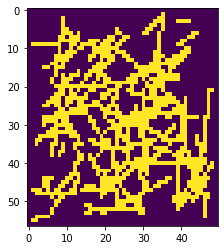

In [18]:
files = sorted(glob.glob(sim_path + 'sim_out_000_000_X.csv'))
xgrid = np.loadtxt(files[0], delimiter=',').T
xgridVec = xgrid.flatten()


files = sorted(glob.glob(sim_path + 'sim_out_000_000_Y.csv'))
ygrid = np.loadtxt(files[0], delimiter=',').T
ygridVec = ygrid.flatten()

def find_nearest_smaller(array, value):
    temp = np.asarray(array).copy()
    temp[temp > value] = 0
    idx = temp.argmax()
    return idx, array[idx]

mat = np.zeros((xgrid.shape[0],xgrid.shape[1],len(meta_list)))

for i, f in enumerate(meta_list):
    # Determine the links' sparsity
    for j, cml in globals()["links_MD_" + str(i)].iterrows():
        xvec = np.linspace(cml.lon1, cml.lon2, xgrid.shape[0])
        yvec = np.linspace(cml.lat1, cml.lat2, ygrid.shape[1])
#         print(xvec, yvec)
        
        for k, vrg in enumerate(zip(xvec, yvec)):
            idx_lon, val_lon = find_nearest_smaller(xgrid[:,0],vrg[0])
            idx_lat, val_lat = find_nearest_smaller(ygrid[0,:],vrg[1])

            mat[idx_lon, idx_lat, i] += 1
            
#         
mat[mat>0] = 1
link_sparsity_vec = np.zeros(len(meta_list))
for i in range(len(meta_list)):
    link_sparsity_vec[i] = np.sum(mat[:,:,i]) / len(mat[:,:,i].flatten())
# link_sparsity_vec = np.sum(mat[::2]) / len(mat.flatten())
print(link_sparsity_vec)
python_algo_flag = 0
plt.imshow(mat[:,:,0])

In [36]:
np.shape(xgrid[:,0])

(57,)

In [19]:
fig, ax = plt.subplots(figsize=(14,5))

ax.pcolormesh(xgrid,ygrid,mat[:,:,0])

line = ax.plot([links_MD_0.lon1.values,links_MD_0.lon2.values],
                    [links_MD_0.lat1.values,links_MD_0.lat2.values],
                    'k', alpha=0.5)

# Approx. lengths of domain

In [20]:
lat_max = np.max(np.loadtxt(sim_path + 'sim_out_000_000_Y.csv', delimiter=','))
lat_min = np.min(np.loadtxt(sim_path + 'sim_out_000_000_Y.csv', delimiter=','))
lon_max = np.max(np.loadtxt(sim_path + 'sim_out_000_000_X.csv', delimiter=','))
lon_min = np.min(np.loadtxt(sim_path + 'sim_out_000_000_X.csv', delimiter=','))

domain_Lx = round(deg2km(lon_min,
                      lon_max,
                      lat_min,
                      lat_min),1)
domain_Ly = round(deg2km(lon_max,
                      lon_max,
                      lat_min,
                      lat_max),1)
print('Length of domain lon axis is approx. ' + str(domain_Lx) +' km')
print('Length of domain lat axis is approx. ' + str(domain_Ly) +' km')

Length of domain lon axis is approx. 15.8 km
Length of domain lat axis is approx. 16.4 km


_____

# Amending (and running) Gomez and kriging- Python


In [21]:
import glob

all_files = glob.glob(sim_path + 'sim_out_*.csv')
files = []
for i in range(len(all_files)):
    if '_X.csv' in all_files[i] or '_Y.csv' in all_files[i] or '_Z.csv' in all_files[i]:
        continue
    else:
        files.append(all_files[i])
files = sorted(files)
files

['/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small10/sim_out_000_000.csv',
 '/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small10/sim_out_000_001.csv',
 '/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small10/sim_out_000_002.csv',
 '/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small10/sim_out_000_003.csv',
 '/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small10/sim_out_000_004.csv',
 '/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small10/sim_out_000_005.csv',
 '/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small10/sim_out_000_006.csv',
 '/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small10/sim_out_000_007.csv',
 '/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small10/sim_out_000_008.csv',
 '/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small10/sim_out_000_009.csv']

In [22]:
import sys
sys.path.append("../my_fuctions/") # the equivalent to "Add to path" in Matlab

from iterative_IDW_V1 import *
# from iterative_IDW import * # Old code (Daniel's)
from geoFunc import *
import kriging as krg

In [23]:
def path_loss_atten(length, freq, gain = 0):
    ''' calculate the attenuation of a link due to path loss
    see en.wikipedia.org/wiki/Free-space_path_loss for details '''    
    # convert=length*freq*(10**12) #conversion units - GHz*km to Hz*m
    # length in KM, freq in GHz, gain in dB
    path_loss = 20*np.log10(length*freq) + 92.45 + gain
    return path_loss

def remove_free_path_loss(df):
    ''' remove free path loss attenuation from df['A'] '''
    df['A'] =  df.apply(lambda cml: cml['A'] - path_loss_atten(cml['L'], cml['F']), axis=1)
    
    # set negative attenuations to 0
    df['A'] = df['A'].apply(lambda a: max(0.0,a))
    
    return df

def lat_lon_to_UTM(df):
    # convert latitude/longitude to UTM (easting/northing in units of meter)
#     p_LL = Proj(init='epsg:4326')
#     p_UTM = Proj(init='epsg:3395')

    df['xa'], df['ya'] = geo2utm(lon_vec=df['xa'].values, lat_vec=df['ya'].values, lon0=33)
    
    df['xb'], df['yb'] = geo2utm(lon_vec=df['xb'].values, lat_vec=df['yb'].values, lon0=33)
#     df['xa'], df['ya'] = transform(p1=p_LL, # lat/lon
#                                   p2=p_UTM, # utm in meters
#                                   x=df['xa'].values, y=df['ya'].values)
    
#     df['xb'], df['yb'] = transform(p1=p_LL, # lat/lon
#                                   p2=p_UTM, # utm in meters
#                                   x=df['xb'].values, y=df['yb'].values)
    return df


In [24]:
# Grid
# This should be the same grid as xgrid of matlab output (above)
py_xgrid = pd.read_csv(str(sim_path + 'sim_out_000_000_X.csv'),header=None).values
py_ygrid = pd.read_csv(str(sim_path + 'sim_out_000_000_Y.csv'),header=None).values

# py_xgrid = py_xgrid.T
# py_ygrid = py_ygrid.T
# py_xgrid.T

### Running Gomez algorithm- python
* To run a simple IDW place a 1 in max_iter

In [25]:
rois = [10.0]# in km
roi = rois[0]
p_pars = [2.0] #np.linspace(1,3,10) 
p_par = p_pars[0]
max_iter = 28#100 # max number of iterrations 
max_iter_for_idw = 0  
Tol = 0.0001 # tolerance
num_of_vg = 3 # number of virtual gauges
num_of_vg_IDW = 1 # number of virtual gauges
shepard_or_cressman = 0 # 0-shep. 1-cress
    
## Fixed Gauge Interval
# fgi = df_linksAndMeta_prep['L'].min() - 0.05 # in km
fgi = 1.0 # km

# if num_of_vg_krg != num_of_vg:
#     print('    ##############################################\n\
#      KRG and GMZ do not have the same no. of vrgs \n\
#     ##############################################')
    
f = open(sim_path + "/list_of_runParam.txt", "r")
for line in f:
    if 'quantization:' in line:
        quantization = float(line.split()[-2])
        break
f.close() 
del f

In [26]:
# convert latitude/longitude to UTM (easting/northing in units of meter)
    
py_xgrid_UTM, py_ygrid_UTM = geo2utm(lon_vec=py_xgrid, lat_vec=py_ygrid, lon0=33)

# # convert latitude/longitude to UTM (easting/northing in units of meter)
# p_LL = Proj(init='epsg:4326')
# p_UTM = Proj(init='epsg:3395')
    
# py_xgrid_UTM, py_ygrid_UTM = transform(p1=p_LL, # lat/lon
#                                p2=p_UTM, # utm in meters
#                                x=py_xgrid, y=py_ygrid)

In [27]:
np.shape(py_xgrid_UTM)

(50, 57)

In [28]:
py_xgrid.shape

(50, 57)

In [29]:
py_ygrid_UTM

array([[3578.18539423, 3578.19020316, 3578.19502001, ..., 3578.45640992,
        3578.46164655, 3578.46689111],
       [3577.85277714, 3577.85758584, 3577.86240245, ..., 3578.12377937,
        3578.12901574, 3578.13426003],
       [3577.5201602 , 3577.52496865, 3577.52978502, ..., 3577.79114895,
        3577.79638506, 3577.80162909],
       ...,
       [3562.55254498, 3562.55734262, 3562.56214816, ..., 3562.82292424,
        3562.82814857, 3562.83338081],
       [3562.21993458, 3562.22473198, 3562.22953727, ..., 3562.49030023,
        3562.4955243 , 3562.50075627],
       [3561.88732432, 3561.89212147, 3561.89692653, ..., 3562.15767635,
        3562.16290016, 3562.16813187]])

In [30]:
print(xgrid.shape)
print(py_xgrid.shape)

(57, 50)
(50, 57)


In [31]:
# example of going back
utm2geo(E=py_xgrid_UTM[0,0], N=py_ygrid_UTM[0,0], lon0=33)

(array(34.8223), array(32.32740098))

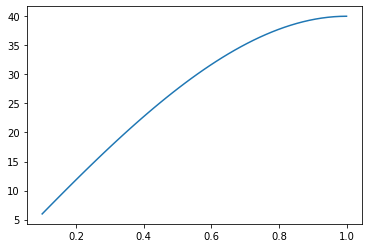

In [32]:
xx = np.linspace(0.1,1,50)
plt.plot(xx, 40*( 1.5*xx/1 - 0.5*(xx/1)**3.0 ))
# 40*( 1.5*xx/2 - 0.5*(xx/2)**3.0 )


### The Dutch parameters

In [33]:
D=1
DOY=186
RANGE = ((15.51*D**0.09+2.06*D**(-0.12)*np.cos((2*np.pi*(DOY-7.37*D**0.22))/365))**4)/1000
SILL = (0.84*D**(-0.25)+0.20*D**(-0.37)*np.cos((2*np.pi*(DOY-162*D**(-0.03)))/365))**4
print(RANGE,SILL)

32.77021047817911 1.0959633805216045


In [34]:
py_xgrid.shape

(50, 57)

### Run only Kriging

In [35]:
f = open(sim_path + "/list_of_runParam.txt", "r")
for line in f:
    if 'std:' in line:
        range_guess = float(split_at(split_at(line,'.',1)[0],'[',1)[-1]) * 4
        range_guess = range_guess / 1e3 # in km
        break
f.close() 
del f
print(range_guess)

4.8


In [39]:
df_linksAndMeta = pd.read_csv(str(files[0]))
df_linksAndMeta.head()

index       SP   Link_num     Freq_1 Polar_1  Freq_2 Polar_2         xa  \
0     70  cellcom  R5TG-4W83  37.580573       V      19       V  34.829309   
1     53  cellcom  0NCV-UBEM  37.959214       V      19       V  34.948692   
2     39  cellcom  J18Q-CE6T  38.119172       H      19       V  34.893636   
3     36  cellcom  61O1-7G5M  16.476881       V      19       V  34.979554   
4     29  cellcom  J0L2-QPF7  17.043711       V      19       V  34.932492   

          ya         xb         yb    Length    ITU_a1    ITU_b1    ITU_a2  \
0  32.222902  34.846727  32.226368  1.682175  0.271678  0.944948  0.061327   
1  32.274716  34.935412  32.280666  1.412144  0.277566  0.942413  0.061327   
2  32.231222  34.888180  32.249015  2.042757  0.316382  0.953674  0.061327   
3  32.270300  34.981980  32.283622  1.497792  0.043147  1.103898  0.061327   
4  32.210109  34.986715  32.212315  5.104059  0.047048  1.096123  0.061327   

     ITU_b2      Rain1      Rain2       A_1       A_2  
0  1.074119  15.074264  16.955473  5.933309  2.157505  
1  1.074119   0.000000   0.000000  0.000000  0.000000  
2  1.074119   0.961914   0.000000  0.622795  0.000000  
3  1.074119   0.070686   0.734028  0.003469  0.065897  
4  1.074119   0.000000   0.709819  0.000000  0.216614

2020-01-11 18:16:27.732102
prepare __init__
Calculation of weights finished
Calculation of weights finished
0.0% of cli 0 starting
2020-01-11 18:17:19.355529
Reusing precalculated weights
Interpolating

Processing finished.

Running kriging
0
bw: 0.3
dist_spacer: 0.02219160368742175
K_matCond: 575.255083606348
condition number = 575.255083606348
 dist_spacer = 0.02219160368742175
 C0 = 127.37601760120072
 a_krg = 4.799999999999999
 min_dist = 0.03138366690571565
 bandwidth (bw) = 0.3
 noise_in_cov_function = False
 exclude links = []
 max rain intensity estimated = 81.2480525390853
Processing finished


0
bw: 0.3
dist_spacer: 0.013635121000858758
K_matCond: 3391.359912050024
condition number = 3391.359912050024
 dist_spacer = 0.013635121000858758
 C0 = 198.5135069305959
 a_krg = 4.799999999999999
 min_dist = 0.0192829730439941
 bandwidth (bw) = 0.3
 noise_in_cov_function = False
 exclude links = []
 max rain intensity estimated = 115.04093013614109
Processing finished


2020-01-11 18:1

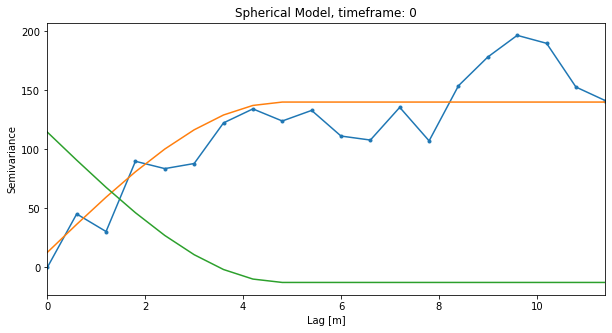

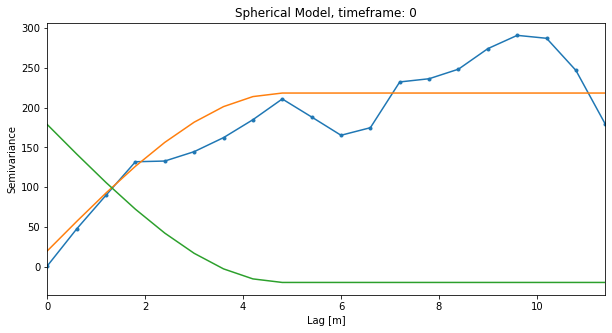

In [36]:
## Run only kriging

import glob
# pre-processing for the iterative IDW algorithm
python_algo_flag = 1
col_names = {'A_1':'A',
             'Length':'L',
             'ITU_a1':'a',
             'ITU_b1':'b',
             'Freq_1':'F',
             'Rain1':'R'}

gomez_iter_vec = np.ones((max_iter, 
                          num_of_ts,
                          num_of_link_iter))*-1


gridded_krg = np.zeros([py_xgrid.shape[1],
                         py_xgrid.shape[0],
                         num_of_ts,
                         num_of_link_iter])
##EquiDistant
gridded_krgED = np.zeros([py_xgrid.shape[1],
                         py_xgrid.shape[0],
                         num_of_ts,
                         num_of_link_iter])

gridded_gmzED = np.zeros([py_xgrid.shape[1],
                         py_xgrid.shape[0],
                         num_of_ts,
                         num_of_link_iter])

gridded_krgEDP2 = np.zeros([py_xgrid.shape[1],
                         py_xgrid.shape[0],
                         num_of_ts,
                         num_of_link_iter])

gridded_gmzEDP2 = np.zeros([py_xgrid.shape[1],
                         py_xgrid.shape[0],
                         num_of_ts,
                         num_of_link_iter])

gridded_krg1 = np.zeros([py_xgrid.shape[1],
                         py_xgrid.shape[0],
                         num_of_ts,
                         num_of_link_iter])



idx_list_to_exclude_ALL = []
idx_list_to_exclude_GLOBAL = []
link_num_list_to_exclude = []
df_exclude_link = pd.DataFrame({'l_num': link_num_list_to_exclude})


for cli in range(num_of_link_iter): # cosen link iteration in lowercase letters
    cliS = split_at(str(format(cli/1000, '.3f')),'.',1)[-1]
    all_files = glob.glob(sim_path + 'sim_out_' + str(cliS) + '_*.csv')
    files = []
    for i in range(len(all_files)):
        if '_X.csv' in all_files[i] or '_Y.csv' in all_files[i] or '_Z.csv' in all_files[i]:
            continue
        else:
            files.append(all_files[i])
    files = sorted(files)
    
    ##################################
    ##################################


    print(str(datetime.datetime.now()))
    print('prepare __init__')
    ## prepare __init__
    df_linksAndMeta = pd.read_csv(str(files[0]))

    df_linksAndMeta_prep = df_linksAndMeta.rename(columns = col_names)

    # take only relevant columns for iterative IDW algoritm
    df_linksAndMeta_prep = df_linksAndMeta_prep[['Link_num','xa','ya','xb','yb','L','a','b','F','R','A']]

#     df_linksAndMeta_prep = remove_free_path_loss(df_linksAndMeta_prep) # remove free path loss from df['A']
    # convert df[['xa','ya','xb','yb']] to UTM (in meters)
    df_linksAndMeta_prep = lat_lon_to_UTM(df_linksAndMeta_prep)
    
    ## Exclude links in advance
    #####################################
    ####################################
#     df_linksAndMeta_prep.sort_values(by=['Link_num'],inplace=True)
#     df_linksAndMeta_prep = df_linksAndMeta_prep.reset_index(drop=True)
#     link_num_list_to_exclude = ['61O1-7G5M']
#     df_linksAndMeta_prep = df_linksAndMeta_prep[~df_linksAndMeta_prep['Link_num'].\
#                                                 isin(link_num_list_to_exclude)]
#     df_linksAndMeta_prep = df_linksAndMeta_prep.reset_index(drop=True)
    ####################################
    ####################################


#     ## prepare Gomez
#     df_linksAndMeta_prep_gmz, num_of_vg = create_virtual_gauges(df_linksAndMeta_prep, 
#                                                                 gauge_length = fgi,
#                                                                 num_gauges=num_of_vg)

#     cml_interp_gmz = IdwIterative(df_linksAndMeta_prep_gmz,
#                               py_xgrid_UTM,
#                               py_ygrid_UTM,
#                               roi, 
#                               max_iter, 
#                               Tol, 
#                               shepard_or_cressman)
    
    ## prepare ED
    df_linksAndMeta_prep_ED, num_of_vg_ED = create_virtual_gauges(df_linksAndMeta_prep, 
                                                                gauge_length = fgi)

    cml_interp_ED = IdwIterative(df_linksAndMeta_prep_ED,
                              py_xgrid_UTM,
                              py_ygrid_UTM,
                              roi, 
                              max_iter, 
                              Tol, 
                              shepard_or_cressman)
    
    ## prepare ED Plus 2
    df_linksAndMeta_prep_EDP2, num_of_vg_EDP2 = create_virtual_gauges(df_linksAndMeta_prep, 
                                                                gauge_length = fgi + 2)

    cml_interp_EDP2 = IdwIterative(df_linksAndMeta_prep_EDP2,
                              py_xgrid_UTM,
                              py_ygrid_UTM,
                              roi, 
                              max_iter, 
                              Tol, 
                              shepard_or_cressman)


    ##################################
    ##################################



    for ts in range(len(files)): # for timestamp
        print(str((ts/len(files))*100) + '% of cli ' + str(cli) + ' starting')
        now = datetime.datetime.now()
        print(str(now))
        df_linksAndMeta = pd.read_csv(str(files[ts]))

        df_linksAndMeta_prep = df_linksAndMeta.rename(columns = col_names)

        # take only relevant columns for iterative IDW algoritm
        df_linksAndMeta_prep = df_linksAndMeta_prep[['Link_num','xa','ya','xb','yb','L','a','b','F','R','A']]

    #     df_linksAndMeta_prep = remove_free_path_loss(df_linksAndMeta_prep) # remove free path loss from df['A']
        # convert df[['xa','ya','xb','yb']] to UTM (in meters)
        df_linksAndMeta_prep = lat_lon_to_UTM(df_linksAndMeta_prep) 
        ## Exclude links in advance
        ####################################
        ####################################
#         df_linksAndMeta_prep.sort_values(by=['Link_num'],inplace=True)
#         df_linksAndMeta_prep = df_linksAndMeta_prep.reset_index(drop=True)
#         df_linksAndMeta_prep = df_linksAndMeta_prep[~df_linksAndMeta_prep['Link_num'].\
#                                                     isin(link_num_list_to_exclude)]
#         df_linksAndMeta_prep = df_linksAndMeta_prep.reset_index(drop=True)
        ####################################
        ####################################

        
        # Create/run IDW VRGs
        df_linksAndMeta_prep_idw, _ = create_virtual_gauges(df_linksAndMeta_prep, 
                                                 gauge_length = fgi, 
                                                 num_gauges=num_of_vg_IDW)
        
        # Create/run EquiDistant VRGs
        df_linksAndMeta_prep_ED, _ = create_virtual_gauges(df_linksAndMeta_prep, 
                                                 gauge_length = fgi)
        algo_out_ED = cml_interp_ED(df_linksAndMeta_prep_ED, quantization)#, interpolate=False)
        iter_vec_ED = cml_interp_ED.dz_vec # saving only the most recent one
        gridded_gmzED[:,:,ts,cli] = algo_out_ED.T
        
        # Create/run EquiDistant P2 VRGs
#         df_linksAndMeta_prep_EDP2, _ = create_virtual_gauges(df_linksAndMeta_prep, 
#                                                  gauge_length = fgi + 2)
#         algo_out_EDP2 = cml_interp_EDP2(df_linksAndMeta_prep_EDP2, quantization)#, interpolate=False)
# #         iter_vec_ED = cml_interp_ED.dz_vec # saving only the most recent one
#         gridded_gmzEDP2[:,:,ts,cli] = algo_out_EDP2.T

#         # Create/run Gomez VRGs
#         df_linksAndMeta_prep_gmz, num_of_vg = create_virtual_gauges(df_linksAndMeta_prep, 
#                                                      gauge_length = fgi, 
#                                                      num_gauges=num_of_vg)

#         algo_out = cml_interp_gmz(df_linksAndMeta_prep_gmz, quantization, interpolate=False)
#         iter_vec = cml_interp_gmz.dz_vec
#         #save iteration vectors in matrix `gomez_iter_vec`
#         gomez_iter_vec[0:len(iter_vec), ts, cli] = iter_vec

        print('Running kriging')
    ## kriging
    #     sill_guess=30
#   #     range_guess=6



            ## run Kriging 1

        df_linksAndMeta_prep_krg1 = df_linksAndMeta_prep_idw.copy()

        algo_out, _ = krg.kriging_execute(df_linksAndMeta_prep_krg1, 
                                       py_xgrid_UTM, 
                                       py_ygrid_UTM,  
                                       range_guess=range_guess,
                                       timestamp=ts,
                                       unit_length='km',
                                       delete_links=True)
        gridded_krg1[:,:,ts,cli] = algo_out.T
        print('\n')
        
#         ## run Kriging with gmz shifted rain 

#         df_linksAndMeta_prep_krg = df_linksAndMeta_prep_gmz.copy()
#         df_linksAndMeta_prep_krg['z'] = tuple(cml_interp_gmz.gauges_z)

#         algo_out, _ = krg.kriging_execute(df_linksAndMeta_prep_krg, 
#                                        py_xgrid_UTM, 
#                                        py_ygrid_UTM, 
#                                        range_guess=range_guess,
#                                        timestamp=ts,
#                                        unit_length='km',
#                                        delete_links=True)
#         gridded_krg[:,:,ts,cli] = algo_out.T
#         print('\n')
        
        
        
        ## run Kriging EquiDistant 

        df_linksAndMeta_prep_krg_ED = df_linksAndMeta_prep_ED.copy()
        df_linksAndMeta_prep_krg_ED['z'] = tuple(cml_interp_ED.gauges_z)

        algo_out_krgED, _ = krg.kriging_execute(df_linksAndMeta_prep_krg_ED, 
                                       py_xgrid_UTM, 
                                       py_ygrid_UTM, 
                                       range_guess=range_guess,
                                       timestamp=ts,
                                       unit_length='km',
                                       delete_links=True)
        gridded_krgED[:,:,ts,cli] = algo_out_krgED.T
        print('\n')
        
        ## run Kriging EquiDistant Plus 2

#         df_linksAndMeta_prep_krg_EDP2 = df_linksAndMeta_prep_EDP2.copy()
#         df_linksAndMeta_prep_krg_EDP2['z'] = tuple(cml_interp_EDP2.gauges_z)

#         algo_out_krgEDP2, _ = krg.kriging_execute(df_linksAndMeta_prep_krg_EDP2, 
#                                        py_xgrid_UTM, 
#                                        py_ygrid_UTM, 
#                                        range_guess=range_guess,
#                                        timestamp=ts,
#                                        unit_length='km',
#                                        delete_links=True)
#         gridded_krgEDP2[:,:,ts,cli] = algo_out_krgEDP2.T
#         print('\n')
        
        
####     globals()['links_MD_' + str(cli)].drop(idx_list_to_exclude_GLOBAL,inplace=True)
    globals()['links_MD_' + str(cli)] = globals()['links_MD_' + str(cli)][~globals()['links_MD_' + \
                                                    str(cli)]['link'].isin(df_exclude_link.l_num.values)]
    globals()['links_MD_' + str(cli)] = globals()['links_MD_' + str(cli)].reset_index(drop=True)

now = datetime.datetime.now()
print(str(now))

In [37]:
df_linksAndMeta_prep_idw.head()

Link_num          xa           ya          xb           yb         L  \
0  R5TG-4W83  672.381398  3566.610797  674.016452  3567.023151  1.682175   
1  0NCV-UBEM  683.528783  3572.553448  682.265908  3573.190590  1.412144   
2  J18Q-CE6T  678.427831  3567.638255  677.878920  3569.602040  2.042757   
3  61O1-7G5M  686.444908  3572.117154  686.646156  3573.598402  1.497792   
4  J0L2-QPF7  682.131742  3565.362653  687.238488  3565.700449  5.104059   

          a         b          F          R         A                     x  \
0  0.271678  0.944948  37.580573  15.074264  5.933309  (673.1989251147986,)   
1  0.277566  0.942413  37.959214   0.000000  0.000000  (682.8973454760564,)   
2  0.316382  0.953674  38.119172   0.961914  0.622795  (678.1533754632463,)   
3  0.043147  1.103898  16.476881   0.070686  0.003469  (686.5455317643839,)   
4  0.047048  1.096123  17.043711   0.000000  0.000000  (684.6851152396152,)   

                       y                       z  
0  (3566.8169743545536,)   (15.074263632656136,)  
1  (3572.8720192560786,)                  (0.0,)  
2  (3568.6201477651316,)   (0.9619135193702008,)  
3   (3572.857777888561,)  (0.07068574429746444,)  
4  (3565.5315509866687,)                  (0.0,)

In [38]:
cml_interp_ED.gauges_z

array([[9.06258396e+00, 2.12245581e+01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.08767067e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.57020327e+00, 1.55201095e-01, 1.19377801e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 4.78383918e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.24476103e-01, 1.82027656e-01, 2.13895516e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.92636308e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [77]:
np.arange(10).reshape((2,-1)).ravel() > 5

array([False, False, False, False, False, False,  True,  True,  True,
        True])

### The 2 cells below were used for producing the data for the simulation paper. They were working with the old GMZ realization of Daniel, and the cell below works with the old kriging of mine. Both of these codes were rewritten by me and are working perfectly with the execution written in `germany_radolan_ana.ipynb` Sep. 2019

In [36]:
# # This cell was used for producing the data for the simulation paper
# # It is working with the old GMZ realization of Daniel, and the cell below 
# # works with the old kriging of mine.
# # Both of these codes were rewritten by me and are working perfectly with
# # the execution written in `germany_radolan_ana.ipynb` Sep. 2019
# import glob
# from scipy.spatial.distance import pdist, squareform
# from scipy.optimize import curve_fit
# # pre-processing for the iterative IDW algorithm
# python_algo_flag = 1
# col_names = {'A_1':'A',
#              'Length':'L',
#              'ITU_a1':'a',
#              'ITU_b1':'b',
#              'Freq_1':'F',
#              'Rain1':'R'}

# gomez_iter_vec = np.ones((max_iter, 
#                           num_of_ts,
#                           num_of_link_iter))*-1

# gridded_gomez = np.zeros([py_xgrid.shape[1],
#                          py_xgrid.shape[0],
#                          num_of_ts,
#                          num_of_link_iter])
# # gridded_gomez = np.zeros([py_xgrid.shape[1],
# #                          py_xgrid.shape[0],
# #                          num_of_ts,
# #                          num_of_link_iter,
# #                          len(rois),
# #                          len(p_pars)])

# gridded_idw = np.zeros([py_xgrid.shape[1],
#                          py_xgrid.shape[0],
#                          num_of_ts,
#                          num_of_link_iter])

# gridded_idwn = np.zeros([py_xgrid.shape[1],
#                          py_xgrid.shape[0],
#                          num_of_ts,
#                          num_of_link_iter])
# # gridded_idw = np.zeros([py_xgrid.shape[1],
# #                          py_xgrid.shape[0],
# #                          num_of_ts,
# #                          num_of_link_iter,
# #                          len(rois),
# #                          len(p_pars)])

# gridded_krg = np.zeros([py_xgrid.shape[1],
#                          py_xgrid.shape[0],
#                          num_of_ts,
#                          num_of_link_iter])

# idx_list_to_exclude_ALL = []
# idx_list_to_exclude_GLOBAL = []
# link_num_list_to_exclude = []
# df_exclude_link = pd.DataFrame({'l_num': link_num_list_to_exclude})

# for cli in range(num_of_link_iter): # cosen link iteration in lowercase letters
#     cliS = split_at(str(format(cli/1000, '.3f')),'.',1)[-1]
#     all_files = glob.glob(sim_path + 'sim_out_' + str(cliS) + '_*.csv')
#     files = []
#     for i in range(len(all_files)):
#         if '_X.csv' in all_files[i] or '_Y.csv' in all_files[i] or '_Z.csv' in all_files[i]:
#             continue
#         else:
#             files.append(all_files[i])
#     files = sorted(files)



#     for ts in range(len(files)): # for timestamp
#         print(str((ts/len(files))*100) + '% of cli ' + str(cli) + ' starting')
#         now = datetime.datetime.now()
#         print(str(now))
#         df_linksAndMeta = pd.read_csv(str(files[ts]))

#         df_linksAndMeta_prep = df_linksAndMeta.rename(columns = col_names)

#         # take only relevant columns for iterative IDW algoritm
#         df_linksAndMeta_prep = df_linksAndMeta_prep[['Link_num','xa','ya','xb','yb','L','a','b','F','R','A']]

#     #     df_linksAndMeta_prep = remove_free_path_loss(df_linksAndMeta_prep) # remove free path loss from df['A']
#         # convert df[['xa','ya','xb','yb']] to UTM (in meters)
#         df_linksAndMeta_prep = lat_lon_to_UTM(df_linksAndMeta_prep) 
# #         import pdb; pdb.set_trace()
#         # compute each cml's average rain rate in df['R'] using df[['A','L','a','b']]
# #         df_linksAndMeta_prep = calc_rain_from_atten(df_linksAndMeta_prep)
# #         df_linksAndMeta_prep = calc_atten_from_rain(df_linksAndMeta_prep)

# #         # Add real gauges
# #         df_realGauges = pd.DataFrame({'xa': [685.885655, 673.499953, 688.428808],
# #                                               'ya': [3565.706661, 3570.105882, 3578.369404],
# #                                               'R': [1.0,2.0,3.0]})
# #         # wrg = with real gauges
# #         df_linksAndMeta_prep_wrg = df_linksAndMeta_prep.append(df_realGauges, ignore_index=True, sort=False)
        

# #         del df_linksAndMeta_prep['F'] # the frequency is not needed from this point on




#         # run IDW
#         df_linksAndMeta_prep_idw = create_virtual_gauges(df_linksAndMeta_prep, 
#                                                      gauge_length = 2.0, 
#                                                      num_gauges=num_of_vg_IDW)
#         if ts == 0:
#             df_test1 = df_linksAndMeta_prep.copy()
#             df_test2 = df_linksAndMeta_prep_idw.copy()
            
#         cml_interp = IdwIterative(roi, max_iter_for_idw, Tol, shepard_or_cressman) # run idw or Oren
#         idw_out = cml_interp(df_linksAndMeta_prep_idw,py_xgrid_UTM,py_ygrid_UTM, quantization)
#         gridded_idw[:,:,ts,cli] = idw_out.T

        
# #######################################################
# #######################################################


#         # run IDWn
#         df_linksAndMeta_prep_idwn = create_virtual_gauges(df_linksAndMeta_prep, 
#                                                      gauge_length = 2.0, 
#                                                      num_gauges=num_of_vg)
#         cml_interp = IdwIterative(roi, max_iter_for_idw, Tol, shepard_or_cressman) # run idw or Oren
#         idwn_out = cml_interp(df_linksAndMeta_prep_idwn,py_xgrid_UTM,py_ygrid_UTM, quantization)
#         gridded_idwn[:,:,ts,cli] = idwn_out.T
        
# ####     globals()['links_MD_' + str(cli)].drop(idx_list_to_exclude_GLOBAL,inplace=True)
#     globals()['links_MD_' + str(cli)] = globals()['links_MD_' + str(cli)][~globals()['links_MD_' + \
#                                                     str(cli)]['link'].isin(df_exclude_link.l_num.values)]
#     globals()['links_MD_' + str(cli)] = globals()['links_MD_' + str(cli)].reset_index(drop=True)

# now = datetime.datetime.now()
# print(str(now))

In [37]:
# ## Working
# import glob
# from scipy.spatial.distance import pdist, squareform
# from scipy.optimize import curve_fit
# # pre-processing for the iterative IDW algorithm
# python_algo_flag = 1
# col_names = {'A_1':'A',
#              'Length':'L',
#              'ITU_a1':'a',
#              'ITU_b1':'b',
#              'Freq_1':'F',
#              'Rain1':'R'}

# gomez_iter_vec = np.ones((max_iter, 
#                           num_of_ts,
#                           num_of_link_iter))*-1

# gridded_gomez = np.zeros([py_xgrid.shape[1],
#                          py_xgrid.shape[0],
#                          num_of_ts,
#                          num_of_link_iter])
# # gridded_gomez = np.zeros([py_xgrid.shape[1],
# #                          py_xgrid.shape[0],
# #                          num_of_ts,
# #                          num_of_link_iter,
# #                          len(rois),
# #                          len(p_pars)])

# gridded_idw = np.zeros([py_xgrid.shape[1],
#                          py_xgrid.shape[0],
#                          num_of_ts,
#                          num_of_link_iter])

# gridded_idwn = np.zeros([py_xgrid.shape[1],
#                          py_xgrid.shape[0],
#                          num_of_ts,
#                          num_of_link_iter])
# # gridded_idw = np.zeros([py_xgrid.shape[1],
# #                          py_xgrid.shape[0],
# #                          num_of_ts,
# #                          num_of_link_iter,
# #                          len(rois),
# #                          len(p_pars)])

# gridded_krg = np.zeros([py_xgrid.shape[1],
#                          py_xgrid.shape[0],
#                          num_of_ts,
#                          num_of_link_iter])

# idx_list_to_exclude_ALL = []
# idx_list_to_exclude_GLOBAL = []
# link_num_list_to_exclude = []
# df_exclude_link = pd.DataFrame({'l_num': link_num_list_to_exclude})

# for cli in range(num_of_link_iter): # cosen link iteration in lowercase letters
#     cliS = split_at(str(format(cli/1000, '.3f')),'.',1)[-1]
#     all_files = glob.glob(sim_path + 'sim_out_' + str(cliS) + '_*.csv')
#     files = []
#     for i in range(len(all_files)):
#         if '_X.csv' in all_files[i] or '_Y.csv' in all_files[i] or '_Z.csv' in all_files[i]:
#             continue
#         else:
#             files.append(all_files[i])
#     files = sorted(files)



#     for ts in range(len(files)): # for timestamp
#         print(str((ts/len(files))*100) + '% of cli ' + str(cli) + ' starting')
#         now = datetime.datetime.now()
#         print(str(now))
#         df_linksAndMeta = pd.read_csv(str(files[ts]))

#         df_linksAndMeta_prep = df_linksAndMeta.rename(columns = col_names)

#         # take only relevant columns for iterative IDW algoritm
#         df_linksAndMeta_prep = df_linksAndMeta_prep[['Link_num','xa','ya','xb','yb','L','a','b','F','R','A']]

#     #     df_linksAndMeta_prep = remove_free_path_loss(df_linksAndMeta_prep) # remove free path loss from df['A']
#         # convert df[['xa','ya','xb','yb']] to UTM (in meters)
#         df_linksAndMeta_prep = lat_lon_to_UTM(df_linksAndMeta_prep) 
# #         import pdb; pdb.set_trace()
#         # compute each cml's average rain rate in df['R'] using df[['A','L','a','b']]
# #         df_linksAndMeta_prep = calc_rain_from_atten(df_linksAndMeta_prep)
# #         df_linksAndMeta_prep = calc_atten_from_rain(df_linksAndMeta_prep)

# #         # Add real gauges
# #         df_realGauges = pd.DataFrame({'xa': [685.885655, 673.499953, 688.428808],
# #                                               'ya': [3565.706661, 3570.105882, 3578.369404],
# #                                               'R': [1.0,2.0,3.0]})
# #         # wrg = with real gauges
# #         df_linksAndMeta_prep_wrg = df_linksAndMeta_prep.append(df_realGauges, ignore_index=True, sort=False)
        

# #         del df_linksAndMeta_prep['F'] # the frequency is not needed from this point on

# #######################################################
# #######################################################
        
#         # run Kriging
# #         # create virtual gauges in df[['x','y','z']] using df[['xa','ya','xb','yb']]
# #         df_linksAndMeta_prep_krg = create_virtual_gauges(df_linksAndMeta_prep, 
# #                                                      gauge_length = 2.0, 
# #                                                      num_gauges=num_of_vg_krg)
# # #         df_linksAndMeta_prep_krg = df_linksAndMeta_prep_krg[:20]
# #         xMax = np.max([df_linksAndMeta_prep_krg.xa.max(), df_linksAndMeta_prep_krg.xb.max()])
# #         xMin = np.min([df_linksAndMeta_prep_krg.xa.min(), df_linksAndMeta_prep_krg.xb.min()])
# #         yMax = np.max([df_linksAndMeta_prep_krg.ya.max(), df_linksAndMeta_prep_krg.yb.max()])
# #         yMin = np.min([df_linksAndMeta_prep_krg.ya.min(), df_linksAndMeta_prep_krg.yb.min()])

# #         bw = 0.3 # in km
# #         # hs = np.arange(0,np.max([xMax-xMin,yMax-yMin]),bw)
# #         # hs = np.arange(0,np.std(p[:,2]),bw)
# #         hs = np.arange(0, np.max([xMax-xMin,yMax-yMin]) / 1.5, bw*2.0)
# #         p_prep = np.array( df_linksAndMeta_prep_krg[['x','y','z']] )
# #         p = np.zeros([len(p_prep[:,0]) * len(p_prep[0,0]),len(p_prep[0,:])])
# #         link_num_prep = []
# #         p_row = 0
# #         element = 0
# #         for row in range(len(p_prep[:,0])):
# #             if row !=0:
# #                 p_row = p_row + element +1
# #             for col in range(len(p_prep[0,:])):
# #                 for element in range(len(p_prep[0,0])):
# #                     p[p_row+element,col] = p_prep[row,col][element]

# #         for row in range(len(p_prep[:,0])):
# #             for element in range(len(p_prep[0,0])):
# #                 link_num_prep.append(df_linksAndMeta_prep_krg['Link_num'][row] )
                
# #         p_original = p.copy()
# #         df_p = pd.DataFrame(p, columns=['x','y','z'])
# #         df_p['l_num'] = link_num_prep
# #         df_p_original = df_p
# #         del p

# #         # Deleting one of 2 links which their centers are too close
# #         K_matCond = 1e9
# #         min_dist = [0.0]
# #         dist_factor = sys.float_info.epsilon
# #         idx_list_to_exclude = []
# #         idx_list_to_exclude_GLOBAL = []
# #         link_num_list_to_exclude = []
# #         Cond = 1
# # #         while Cond == 1:
# #         while K_matCond >= 10000:
# # #             sv = []
# #             dist_factor = dist_factor + 0.01 # 10 meters
# #             # minimum distance between virtual gauges to allow inversion of K
# #             min_dist = pdist( [[np.abs(py_xgrid_UTM[1,0]-py_xgrid_UTM[0,0]) + np.mean(py_xgrid_UTM[:,0]),
# #                                 np.abs(py_ygrid_UTM[1,0]-py_ygrid_UTM[0,0]) + np.mean(py_ygrid_UTM[:,0])],
# #                               [np.abs(py_xgrid_UTM[1,0]-py_xgrid_UTM[0,0]) + dist_factor + np.mean(py_xgrid_UTM[:,0]),
# #                                 np.abs(py_ygrid_UTM[1,0]-py_ygrid_UTM[0,0]) + dist_factor + np.mean(py_ygrid_UTM[:,0])]] )

# #             dist_temp = squareform(pdist( df_p[['x','y']] ))
# #             # loop over the upper part of the dist matrix
# #             idx_list_to_exclude_ALL = []
# #             idx_list_to_exclude_GLOBAL = []
# #             for row in range(len(df_p)-1):
# #                 for col in range(row+1,len(df_p)):
# #                     if np.max(dist_temp[row,col]) <= min_dist[0]: 
# #                         idx_list_to_exclude_GLOBAL.append(int(np.floor(row/num_of_vg_krg))) # idx of links to exclude
# #                         link_num_list_to_exclude.append(link_num_prep[row]) # name of links to exclude
# #                         idx_list_to_exclude_ALL.append(row) # idx of vg to exclude
                        
# #             df_p = df_p[~df_p['l_num'].isin(link_num_list_to_exclude)]
# #             df_p = df_p.reset_index(drop=True)

# #             p = df_p[['x','y','z']].values
# #             sv = krg.SV( p, hs, bw )
# #             # optimization of params
# # #             popt, pcov = curve_fit(f=krg.func_to_opt, xdata=sv[0], ydata=sv[1], 
# # #                                    bounds=(0, [150, 40])) 
# # #             C0, a_krg = popt # C0 is the sill and a_krg is the range
# # ######################################################################
# # ######################################################################
# #             C0=SILL; a_krg=RANGE
# # ######################################################################
# # ######################################################################
# # #             import pdb; pdb.set_trace()

# #             cov_func = lambda h: C0 - krg.func_to_opt( h, C0, a_krg )

# #             # number of neighboring points to consider
# #             N = np.shape(p)[0]
# #             # form a matrix of distances between existing data points
# #             K = squareform( pdist( df_p[['x','y']] ) )
# #             #apply the covariance model to these distances
# #             K = cov_func( K.ravel() )
# #             K = np.array( K )
# #             K = K.reshape( N,N )
# #             K_inv = np.linalg.inv( K )
# #             K_matCond = np.linalg.cond( K )
# # #             print(np.linalg.cond( K ))
# # #             print(ts)
# #             Cond = Cond + 1
    
# #         df_exclude_link = pd.DataFrame({'l_num': link_num_list_to_exclude})
# #         df_exclude_link.l_num.unique()    
# #         print('condition number = ' + str(K_matCond) + '\n', 'dist_factor = ' + str(dist_factor) + '\n', \
# #              'C0 = ' + str(C0) + '\n', 'a_krg = ' + str(a_krg) + '\n', 'min_dist = ' \
# #               + str(min_dist[0]) + '\n',\
# #               'exclude links =' + str(df_exclude_link.l_num.values) )
# #         # plotting the semivariogram
# # #         plt.fig, ax = plt.subplots(figsize=(10,5))
# # #         ax.plot( sv[0], sv[1], '.-' )
# # #         plt.xlim(0,np.max(sv[0]))
# # #         ax.plot( sv[0], krg.func_to_opt( sv[0], C0, a_krg ) )
# # #         ax.plot( sv[0], cov_func(sv[0]) )
# # #         ax.set_title('Spherical Model')
# # #         ax.set_ylabel('Semivariance')
# # #         ax.set_xlabel('Lag [km]')
        
# #         temp = np.zeros(np.shape(py_xgrid_UTM.flatten()))
# # #         temp_weights = np.zeros(np.shape(py_xgrid_UTM.flatten()))
# #         for i, (xi, yj) in enumerate(zip(py_xgrid_UTM.flatten(),py_ygrid_UTM.flatten())):
# #             temp[i], _ = krg.krige( p, (xi,yj), N, cov_func, K_inv)
# #         gridded_krg[:,:,ts,cli] = temp.reshape(np.shape(py_xgrid_UTM)).T
# # #         gridded_krg_weights[:,:,ts,cli] = temp_weights.reshape(np.shape(py_xgrid_UTM)).T
        
# #         print(' max rain intensity estimated = ' + str(np.max(gridded_krg[:,:,ts,cli])))
    

# #         df_linksAndMeta_prep = df_linksAndMeta_prep[~df_linksAndMeta_prep['Link_num'].isin(df_exclude_link.l_num.values)]
# #         df_linksAndMeta_prep = df_linksAndMeta_prep.reset_index()
        
# #######################################################
# #######################################################


#         # run Gomez
# #         df_linksAndMeta_prep_gmz = create_virtual_gauges(df_linksAndMeta_prep, 
# #                                                      gauge_length = 2.0, 
# #                                                      num_gauges=num_of_vg)
        
# #         cml_interp = IdwIterative(roi, max_iter, Tol, shepard_or_cressman) # run idw or Oren
# #         algo_out = cml_interp(df_linksAndMeta_prep_gmz,py_xgrid_UTM,py_ygrid_UTM, quantization)
# #         iter_vec = cml_interp.dz_vec
# #         #save iteration vectors in matrix `gomez_iter_vec`
# #         gomez_iter_vec[0:len(iter_vec), ts, cli] = iter_vec
# #     #     gomez_iter_vec = np.c_[gomez_iter_vec, np.ones((max_iter,1))*-1]
# #         gridded_gomez[:,:,ts,cli] = algo_out.T 

# #######################################################
# #######################################################


#         # run IDW
#         df_linksAndMeta_prep_idw = create_virtual_gauges(df_linksAndMeta_prep, 
#                                                      gauge_length = 2.0, 
#                                                      num_gauges=num_of_vg_IDW)
#         if ts == 0:
#             df_test1 = df_linksAndMeta_prep.copy()
#             df_test2 = df_linksAndMeta_prep_idw.copy()
            
#         cml_interp = IdwIterative(roi, max_iter_for_idw, Tol, shepard_or_cressman) # run idw or Oren
#         idw_out = cml_interp(df_linksAndMeta_prep_idw,py_xgrid_UTM,py_ygrid_UTM, quantization)
#         gridded_idw[:,:,ts,cli] = idw_out.T

        
# #######################################################
# #######################################################


#         # run IDWn
#         df_linksAndMeta_prep_idwn = create_virtual_gauges(df_linksAndMeta_prep, 
#                                                      gauge_length = 2.0, 
#                                                      num_gauges=num_of_vg)
#         cml_interp = IdwIterative(roi, max_iter_for_idw, Tol, shepard_or_cressman) # run idw or Oren
#         idwn_out = cml_interp(df_linksAndMeta_prep_idwn,py_xgrid_UTM,py_ygrid_UTM, quantization)
#         gridded_idwn[:,:,ts,cli] = idwn_out.T
        
# ####     globals()['links_MD_' + str(cli)].drop(idx_list_to_exclude_GLOBAL,inplace=True)
#     globals()['links_MD_' + str(cli)] = globals()['links_MD_' + str(cli)][~globals()['links_MD_' + \
#                                                     str(cli)]['link'].isin(df_exclude_link.l_num.values)]
#     globals()['links_MD_' + str(cli)] = globals()['links_MD_' + str(cli)].reset_index(drop=True)

# now = datetime.datetime.now()
# print(str(now))

In [38]:
# %matplotlib notebook
# fig, ax = plt.subplots(1, 2, figsize=(15,6), sharex=True, sharey=True)#figsize=(15,10),
# ax[0].plot(df_p_original.x,df_p_original.y, 'ro', alpha = 0.5)
# ax[1].plot(df_p.x,df_p.y, 'ro', alpha = 0.5)
# # for i in range(p_original.shape[0]):
# #     if i in idx_list_to_exclude_ALL:
# #         ax[0].text(p_original[i,0], p_original[i,1], str(i), fontsize=20)
# #         ax[0].plot(p_original[i,0],p_original[i,1], 'bo', alpha = 0.5)
# #     else:
# #         ax[0].text(p_original[i,0], p_original[i,1], str(i))
# ax[0].set_title('Points prior to exclusion')
# ax[1].set_title('Points remained')

In [39]:
# %matplotlib notebook
# fig, ax = plt.subplots(1, 2, figsize=(15,6), sharex=True, sharey=True)#figsize=(15,10),
# ax[0].plot(p_original[:,0],p_original[:,1], 'ro', alpha = 0.5)
# ax[1].plot(p[:,0],p[:,1], 'ro', alpha = 0.5)
# for i in range(p_original.shape[0]):
#     if i in idx_list_to_exclude_ALL:
#         ax[0].text(p_original[i,0], p_original[i,1], str(i), fontsize=20)
#         ax[0].plot(p_original[i,0],p_original[i,1], 'bo', alpha = 0.5)
#     else:
#         ax[0].text(p_original[i,0], p_original[i,1], str(i))
# ax[0].set_title('Points to exclude')
# ax[1].set_title('Points remained')

In [40]:
%matplotlib inline
%matplotlib inline

In [41]:
# %matplotlib inline
# weights_dutch = ([-8.68170058e-02, -1.84215628e-02, -6.92305781e-04, -6.44748347e-03,
#         1.73945824e-02,  1.09314115e-02, -4.24624852e-03, -3.73172415e-03,
#         1.12339251e-02, -5.78011082e-03,  3.07904968e-01, -5.94948754e-03,
#         1.41711156e-02, -2.25315507e-03,  2.17507002e-03, -6.59136328e-02,
#        -3.81397130e-02,  8.14890732e-03,  1.21398825e-02, -1.98231822e-02,
#         1.37776183e-01,  6.43401131e-02, -2.71304355e-03, -4.88080012e-03,
#        -1.16751141e-02,  9.27999836e-02, -1.32214421e-02, -1.38768970e-04,
#        -1.71787400e-02, -1.58924517e-03, -1.35570746e-03, -4.30484417e-03,
#        -1.08652386e-01, -8.73651937e-03, -2.31515547e-02,  7.52647318e-01,
#         1.84442790e-03, -2.25524151e-03, -6.85567227e-03,  6.92939431e-03,
#        -1.10617757e-02, -4.45866920e-03, -2.77756607e-02, -6.93703000e-04,
#         1.32106890e-03, -6.17842650e-02,  7.06281387e-02])

# weights_me = ([-6.90490169e-02, -4.29232606e-02, -1.48552511e-02,  5.61357242e-02,
#        -1.54775554e-03, -2.17115798e-02,  1.10087690e-02,  7.47485035e-03,
#         4.78021532e-04,  2.62620437e-02,  2.44103074e-01, -2.26885879e-02,
#         1.21221983e-03,  3.53126098e-02,  1.28875832e-03, -4.94068245e-02,
#        -3.79068644e-02, -1.20942784e-02, -7.17096799e-03, -8.35126951e-03,
#        -6.51372047e-03, -3.86801180e-02, -2.68009533e-02, -1.32052733e-02,
#         6.03517599e-03,  1.75692469e-02, -2.68783540e-03,  7.92447678e-03,
#        -1.31516523e-02,  1.04241874e-02, -1.21567410e-02,  4.21479256e-02,
#        -6.22449987e-02,  1.80788752e-02, -2.21998369e-02,  5.88011110e-01,
#         4.02651025e-03,  5.00122074e-02,  4.28349631e-03, -1.91273924e-02,
#        -2.01800690e-03,  1.12845751e-02, -7.18006137e-02, -2.78955019e-02,
#        -1.01926525e-02, -5.31492404e-02,  2.75071107e-02])

# plt.fig, ax = plt.subplots(figsize=(10,5))
# ax.plot( weights_me )
# ax.plot( weights_dutch, '.-' )

In [42]:
%matplotlib inline

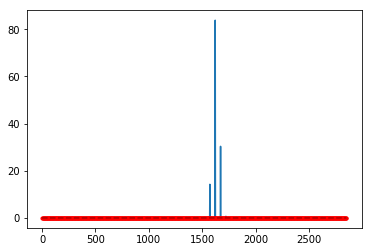

In [43]:
%matplotlib inline
ts=0
cli=0
plt.plot(gridded_sim[:,:,ts,cli].flatten())
# plt.plot(gridded_gomez[:,:,ts,cli].flatten())
# plt.plot(gridded_idw[:,:,ts,cli].flatten(),'--g', alpha=0.9)
plt.plot(gridded_krg[:,:,ts,cli].flatten(),'.r', alpha=0.3)
plt.plot(gridded_krg1[:,:,ts,cli].flatten(),'--k', alpha=0.3)

In [44]:
# plt.style.use('default')
# plt.imshow(gridded_sim[:,:,ts,cli])

In [45]:
# plt.imshow(gridded_krg[:,:,ts,cli])

In [46]:
# plt.imshow(ds_sim_GT.raindepth[:,:,ts,cli])

In [47]:
# plt.imshow(ds_sim_GT.raindepth.isel(time=ts, link_iter=cli))

In [48]:
list_of_datasets

['ds_sim_GT']

In [49]:
sim_path

'/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small2/'

In [50]:
# df_realGauges = pd.DataFrame({'xa': [685.885655, 673.499953, 688.428808],
#                                       'ya': [3565.706661, 3570.105882, 3578.369404],
#                                       'R': [1.0,2.0,3.0]})
        
# df_linksAndMeta_prep = df_linksAndMeta_prep.append(df_realGauges, ignore_index=True, sort=False)
# df_linksAndMeta_prep.tail(10)

In [51]:
# cml_interp.Z

In [52]:
# cml_interp.gauges_z
# cml_interp.df.num_of_gauges

In [78]:
## Gomez dataSet:
# name_of_sim = str(str(int(roi)) + 'roi_Gomez' + str(num_of_vg) + '_py')
# globals()["ds_" + name_of_sim] = xr.Dataset(data_vars={'raindepth': (('y', 'x', 'time', 'link_iter'), gridded_gomez),
#                                                       'iter_for_conv': (('iter', 'time', 'link_iter'), gomez_iter_vec)},
#                                             coords={'lon_grid': (('y', 'x'), py_xgrid.T),
#                                                     'lat_grid': (('y', 'x'), py_ygrid.T),
#                                                     'iter': range(gomez_iter_vec.shape[0]),
#                                                     'time': timestamps.values,
#                                                     'link_iter': range(num_of_link_iter)})


# globals()["ds_" + name_of_sim].raindepth.attrs['units'] = 'mm'

# if str("ds_" + name_of_sim) in list_of_datasets:
#     print('Dataset already in list_of_datasets')
# else: 
#     list_of_datasets.append(str("ds_" + name_of_sim))


# # IDW python dataSet:
# name_of_sim = str(str(int(roi)) + 'roi_IDW' + str(num_of_vg_IDW) + '_py')
# globals()["ds_" + name_of_sim] = xr.Dataset(data_vars={'raindepth': (('y', 'x', 'time', 'link_iter'), gridded_idw),
#                                                       'iter_for_conv': (('iter', 'time', 'link_iter'), gomez_iter_vec*-1)},
#                                             coords={'lon_grid': (('y', 'x'), py_xgrid.T),
#                                                     'lat_grid': (('y', 'x'), py_ygrid.T),
#                                                     'iter': range(gomez_iter_vec.shape[0]),
#                                                     'time': timestamps.values,
#                                                     'link_iter': range(num_of_link_iter)})


# globals()["ds_" + name_of_sim].raindepth.attrs['units'] = 'mm'

# if str("ds_" + name_of_sim) in list_of_datasets:
#     print('Dataset already in list_of_datasets')
# else: 
#     list_of_datasets.append(str("ds_" + name_of_sim))


# # IDWn python dataSet:
# name_of_sim = str(str(int(roi)) + 'roi_IDW' + str(num_of_vg) + '_py')
# globals()["ds_" + name_of_sim] = xr.Dataset(data_vars={'raindepth': (('y', 'x', 'time', 'link_iter'), gridded_idwn),
#                                                       'iter_for_conv': (('iter', 'time', 'link_iter'), gomez_iter_vec*-1)},
#                                             coords={'lon_grid': (('y', 'x'), py_xgrid.T),
#                                                     'lat_grid': (('y', 'x'), py_ygrid.T),
#                                                     'iter': range(gomez_iter_vec.shape[0]),
#                                                     'time': timestamps.values,
#                                                     'link_iter': range(num_of_link_iter)})


# globals()["ds_" + name_of_sim].raindepth.attrs['units'] = 'mm'

# if str("ds_" + name_of_sim) in list_of_datasets:
#     print('Dataset already in list_of_datasets')
# else: 
#     list_of_datasets.append(str("ds_" + name_of_sim))


# Gomez ED dataSet:
name_of_sim = str(str(int(roi)) + 'roi_Gomez' + num_of_vg_ED + '_py')
globals()["ds_" + name_of_sim] = xr.Dataset(data_vars={'raindepth': (('y', 'x', 'time', 'link_iter'), gridded_gmzED),
                                                      'iter_for_conv': (('iter', 'time', 'link_iter'), gomez_iter_vec*-1)},
                                            coords={'lon_grid': (('y', 'x'), py_xgrid.T),
                                                    'lat_grid': (('y', 'x'), py_ygrid.T),
                                                    'iter': range(gomez_iter_vec.shape[0]),
                                                    'time': timestamps.values,
                                                    'link_iter': range(num_of_link_iter)})


globals()["ds_" + name_of_sim].raindepth.attrs['units'] = 'mm'

if str("ds_" + name_of_sim) in list_of_datasets:
    print('Dataset already in list_of_datasets')
else: 
    list_of_datasets.append(str("ds_" + name_of_sim))
    
    
# Gomez ED PX dataSet:
name_of_sim = str(str(int(roi)) + 'roi_Gomez' + num_of_vg_EDP2 + '_py')
globals()["ds_" + name_of_sim] = xr.Dataset(data_vars={'raindepth': (('y', 'x', 'time', 'link_iter'), gridded_gmzEDP2),
                                                      'iter_for_conv': (('iter', 'time', 'link_iter'), gomez_iter_vec*-1)},
                                            coords={'lon_grid': (('y', 'x'), py_xgrid.T),
                                                    'lat_grid': (('y', 'x'), py_ygrid.T),
                                                    'iter': range(gomez_iter_vec.shape[0]),
                                                    'time': timestamps.values,
                                                    'link_iter': range(num_of_link_iter)})


globals()["ds_" + name_of_sim].raindepth.attrs['units'] = 'mm'

if str("ds_" + name_of_sim) in list_of_datasets:
    print('Dataset already in list_of_datasets')
else: 
    list_of_datasets.append(str("ds_" + name_of_sim))
    
    
# # Kriging dataSet:
# name_of_sim = str('kriging' + str(num_of_vg) + '_py')
# globals()["ds_" + name_of_sim] = xr.Dataset(data_vars={'raindepth': (('y', 'x', 'time', 'link_iter'), 
#                                                                      gridded_krg),
#                                                       'iter_for_conv': (('iter', 'time', 'link_iter'), 
#                                                                         gomez_iter_vec*-1)},
#                                             coords={'lon_grid': (('y', 'x'), py_xgrid.T),
#                                                     'lat_grid': (('y', 'x'), py_ygrid.T),
#                                                     'iter': range(gomez_iter_vec.shape[0]),
#                                                     'time': timestamps.values,
#                                                     'link_iter': range(num_of_link_iter)})


# globals()["ds_" + name_of_sim].raindepth.attrs['units'] = 'mm'

# if str("ds_" + name_of_sim) in list_of_datasets:
#     print('Dataset already in list_of_datasets')
# else: 
#     list_of_datasets.append(str("ds_" + name_of_sim))
    
    
    # Kriging ED dataSet:
name_of_sim = str('kriging' + num_of_vg_ED + '_py')
globals()["ds_" + name_of_sim] = xr.Dataset(data_vars={'raindepth': (('y', 'x', 'time', 'link_iter'), 
                                                                     gridded_krgED),
                                                      'iter_for_conv': (('iter', 'time', 'link_iter'), 
                                                                        gomez_iter_vec*-1)},
                                            coords={'lon_grid': (('y', 'x'), py_xgrid.T),
                                                    'lat_grid': (('y', 'x'), py_ygrid.T),
                                                    'iter': range(gomez_iter_vec.shape[0]),
                                                    'time': timestamps.values,
                                                    'link_iter': range(num_of_link_iter)})


globals()["ds_" + name_of_sim].raindepth.attrs['units'] = 'mm'

if str("ds_" + name_of_sim) in list_of_datasets:
    print('Dataset already in list_of_datasets')
else: 
    list_of_datasets.append(str("ds_" + name_of_sim))

    
    # Kriging EDPX dataSet:
name_of_sim = str('kriging' + num_of_vg_EDP2 + '_py')
globals()["ds_" + name_of_sim] = xr.Dataset(data_vars={'raindepth': (('y', 'x', 'time', 'link_iter'), 
                                                                     gridded_krgEDP2),
                                                      'iter_for_conv': (('iter', 'time', 'link_iter'), 
                                                                        gomez_iter_vec*-1)},
                                            coords={'lon_grid': (('y', 'x'), py_xgrid.T),
                                                    'lat_grid': (('y', 'x'), py_ygrid.T),
                                                    'iter': range(gomez_iter_vec.shape[0]),
                                                    'time': timestamps.values,
                                                    'link_iter': range(num_of_link_iter)})


globals()["ds_" + name_of_sim].raindepth.attrs['units'] = 'mm'

if str("ds_" + name_of_sim) in list_of_datasets:
    print('Dataset already in list_of_datasets')
else: 
    list_of_datasets.append(str("ds_" + name_of_sim))
    
    
# # Kriging 1 dataSet:
# name_of_sim = str('kriging' + str(num_of_vg_IDW) + '_py')
# globals()["ds_" + name_of_sim] = xr.Dataset(data_vars={'raindepth': (('y', 'x', 'time', 'link_iter'), 
#                                                                      gridded_krg1),
#                                                       'iter_for_conv': (('iter', 'time', 'link_iter'), 
#                                                                         gomez_iter_vec*-1)},
#                                             coords={'lon_grid': (('y', 'x'), py_xgrid.T),
#                                                     'lat_grid': (('y', 'x'), py_ygrid.T),
#                                                     'iter': range(gomez_iter_vec.shape[0]),
#                                                     'time': timestamps.values,
#                                                     'link_iter': range(num_of_link_iter)})


# globals()["ds_" + name_of_sim].raindepth.attrs['units'] = 'mm'

# if str("ds_" + name_of_sim) in list_of_datasets:
#     print('Dataset already in list_of_datasets')
# else: 
#     list_of_datasets.append(str("ds_" + name_of_sim))


    
print(list_of_datasets)
globals()["ds_" + name_of_sim]


Dataset already in list_of_datasets
Dataset already in list_of_datasets
Dataset already in list_of_datasets
Dataset already in list_of_datasets
['ds_sim_GT', 'ds_10roi_GomezED1000_py', 'ds_10roi_GomezED3000_py', 'ds_krigingED1000_py', 'ds_krigingED3000_py']


<xarray.Dataset>
Dimensions:        (iter: 28, link_iter: 1, time: 10, x: 50, y: 57)
Coordinates:
    lon_grid       (y, x) float64 34.82 34.82 34.82 34.82 ... 34.99 34.99 34.99
    lat_grid       (y, x) float64 32.33 32.32 32.32 32.32 ... 32.19 32.18 32.18
  * iter           (iter) int64 0 1 2 3 4 5 6 7 8 ... 19 20 21 22 23 24 25 26 27
  * time           (time) datetime64[ns] 2010-01-23T12:00:00 ... 2010-01-23T21:00:00
  * link_iter      (link_iter) int64 0
Dimensions without coordinates: x, y
Data variables:
    raindepth      (y, x, time, link_iter) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    iter_for_conv  (iter, time, link_iter) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0

________

# Plotting algorithms' output

In [60]:
# list_of_datasets.remove('ds_kriging1_py')
list_of_datasets


['ds_sim_GT',
 'ds_10roi_GomezED1000_py',
 'ds_10roi_GomezED3000_py',
 'ds_krigingED1000_py',
 'ds_krigingED3000_py']

In [79]:
# Define rows and columns numbers in timestamps plots
rows_in_fig=int(np.ceil(len(list_of_datasets)/3))
cols_in_fig=int(np.ceil(len(list_of_datasets)/2))
if len(list_of_datasets) <= 3:
    cols_in_fig = cols_in_fig + 1
rows_in_fig

2

Choose which link setting you wish to see

In [73]:
CLI = 0 # Chosen Links Iteration index
# CPI = 0 # Chose p value iteration
# CRI = 0 # Chose roi value iteration

In [63]:
# 3D Snapshots
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.tri as mtri

# plt.style.use('default')
# # snapshot = 0
# for snapshot in range(len(globals()[list_of_datasets[0]]['time'])):
#     fig = plt.figure(figsize=(13,9))
#     i=0

#     for i in range(len(list_of_datasets)):
#         ax = fig.add_subplot(rows_in_fig, cols_in_fig, i+1, projection='3d')
#         ax.set_zlim(0, 25)
#         ax.plot_surface(globals()[list_of_datasets[i]].lon_grid.values,
#                         globals()[list_of_datasets[i]].lat_grid.values,
#                         globals()[list_of_datasets[i]].raindepth.isel(time=snapshot, 
#                                                                       link_iter=CLI))
#         ax.set_title(list_of_datasets[i] + '   snapshot ' + str(snapshot))


In [64]:
xgrid.shape

(57, 50)

In [65]:
# timestamp = -1
# www=(ds_6roi_Gomez3['raindepth'].values[:,:,timestamp,CLI] - ds_6roi_IDW1['raindepth'].values[:,:,timestamp,CLI])
# plt.pcolormesh(xgrid,ygrid,www)

# for y in range(ygrid[0,:].shape[0]):
#     for x in range(xgrid[:,0].shape[0]):
#         plt.text(xgrid[x,0] + 0.005, ygrid[0,y] - 0.005, '%.2f' % www[x, y],
#                  horizontalalignment='center',
#                  verticalalignment='center')

# plt.show()

### Check convergence

There is some problem here when there are nans

In [66]:
# # style
# plt.style.use('seaborn-darkgrid')
# # plt.style.use('default')

# length_of_conv = []
# for item in range(len(list_of_datasets)):
#     if 'Gomez' in list_of_datasets[item]:
#         length_of_conv = len(globals()[list_of_datasets[item]]['iter_for_conv'].values[1,:])
#         break
#     else:
#         continue

# fig, ax = plt.subplots(length_of_conv,
#                        1, 
#                        figsize=(7,20), 
#                        sharex=True)
# sizes = 10

# for it in range(length_of_conv):
#     if len(range(length_of_conv))==1:
#         for item in list_of_datasets:
#             if item == 'ds_sim_GT' or 'IDW' in item or 'kriging' in item: # the ground truth has no iterations apparently...
#                 continue
#             ax.plot(globals()[item]['iter'], 
#                        globals()[item]['iter_for_conv'].values[:,it], 
#                        label= item)
#         ax.set_xlabel('Number of iter.',fontsize=sizes)
#         ax.set_ylabel('Val for snapshot ' + str(it),fontsize=sizes)
#         ax.tick_params(labelsize=sizes)
#         ax.legend(fontsize=sizes, loc=1)
#         ax.set_ylim([0,0.005])
        
#     else:
#         for item in list_of_datasets:
#             if item == 'ds_sim_GT' or 'IDW' in item or 'kriging' in item: # the ground truth has no iterations apparently...
#                 continue
#             ax[it].plot(globals()[item]['iter'], 
#                        globals()[item]['iter_for_conv'].values[:,it], 
#                        label= item)
#         ax[it].set_xlabel('Number of iter.',fontsize=sizes)
#         ax[it].set_ylabel('Val for snapshot ' + str(it),fontsize=sizes)
#         ax[it].tick_params(labelsize=sizes)
#         ax[it].legend(fontsize=sizes, loc=1)
#         ax[it].set_ylim([0,0.005])


# plt.style.use('default')


### 2D presentation of rainfields


In [80]:
CLI = 0 # Chosen link iter

In [74]:
list_of_datasets

['ds_sim_GT',
 'ds_10roi_GomezED1000_py',
 'ds_10roi_GomezED3000_py',
 'ds_krigingED1000_py',
 'ds_krigingED3000_py']

50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50


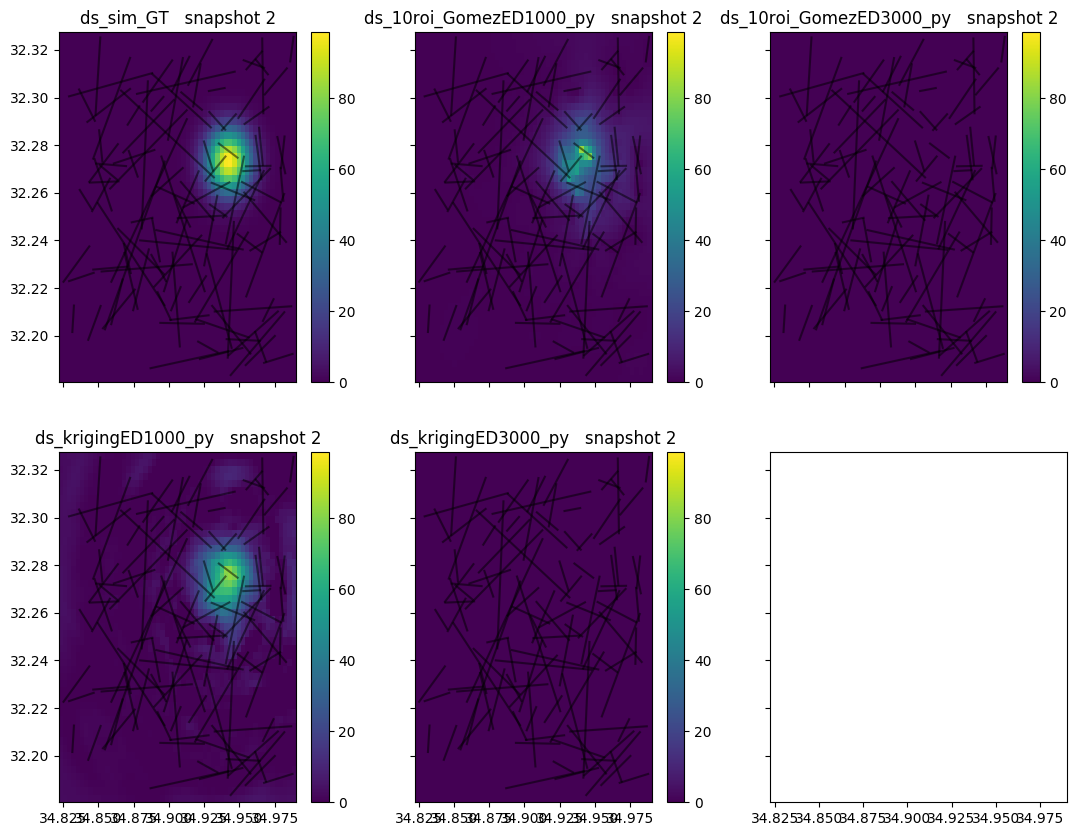

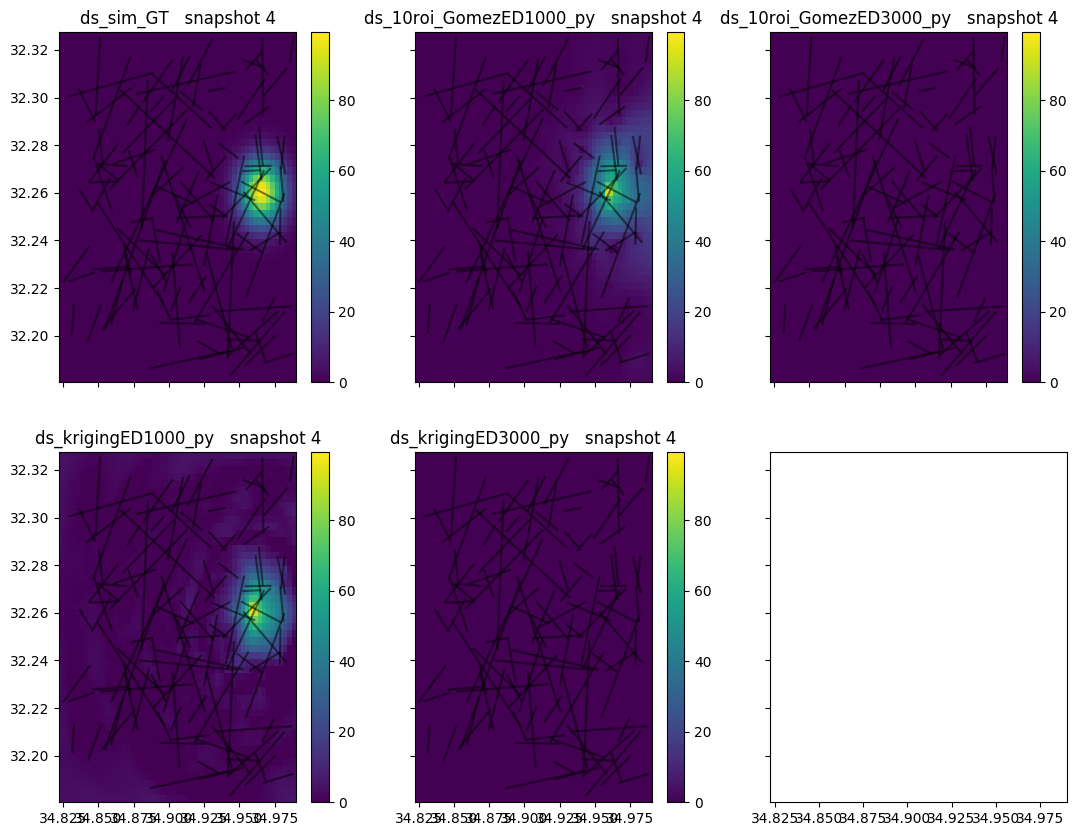

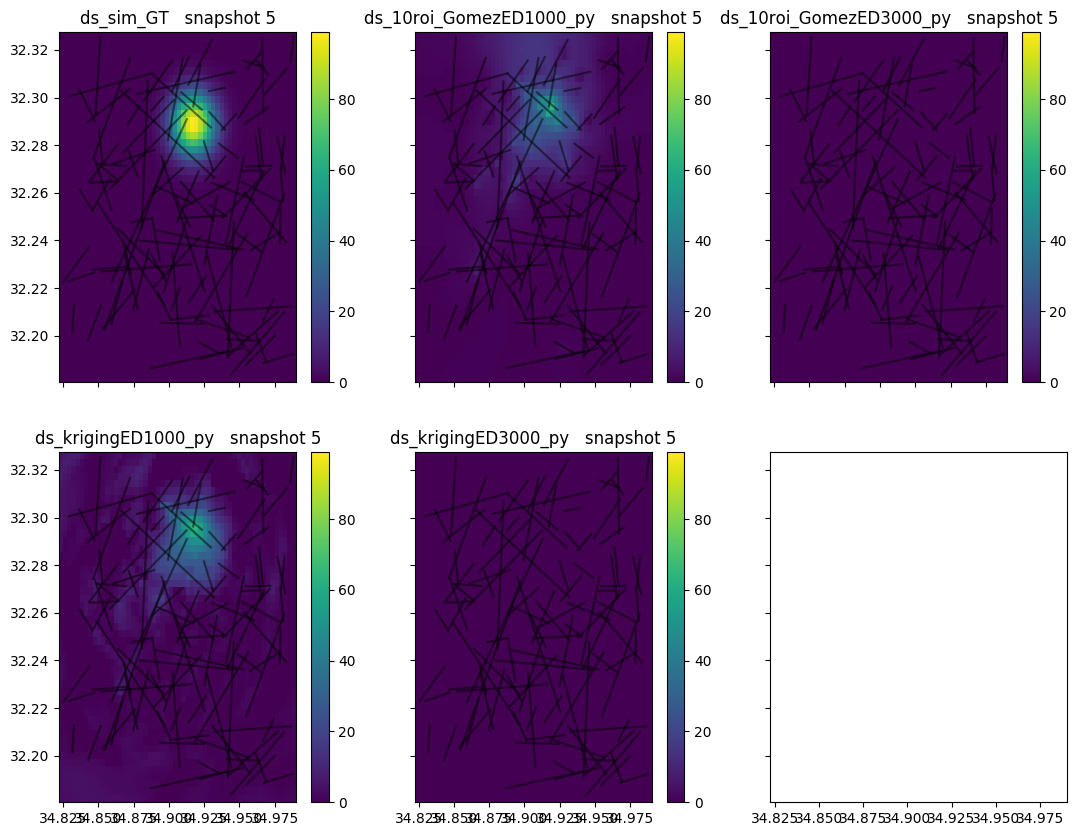

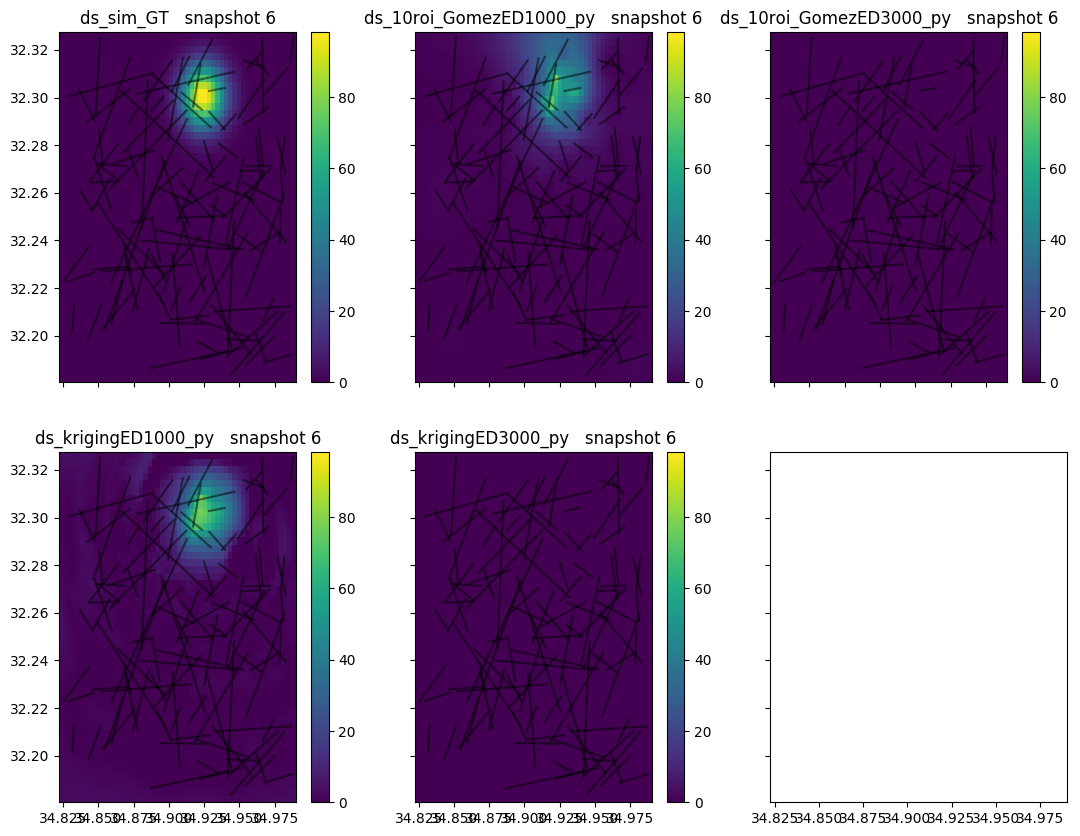

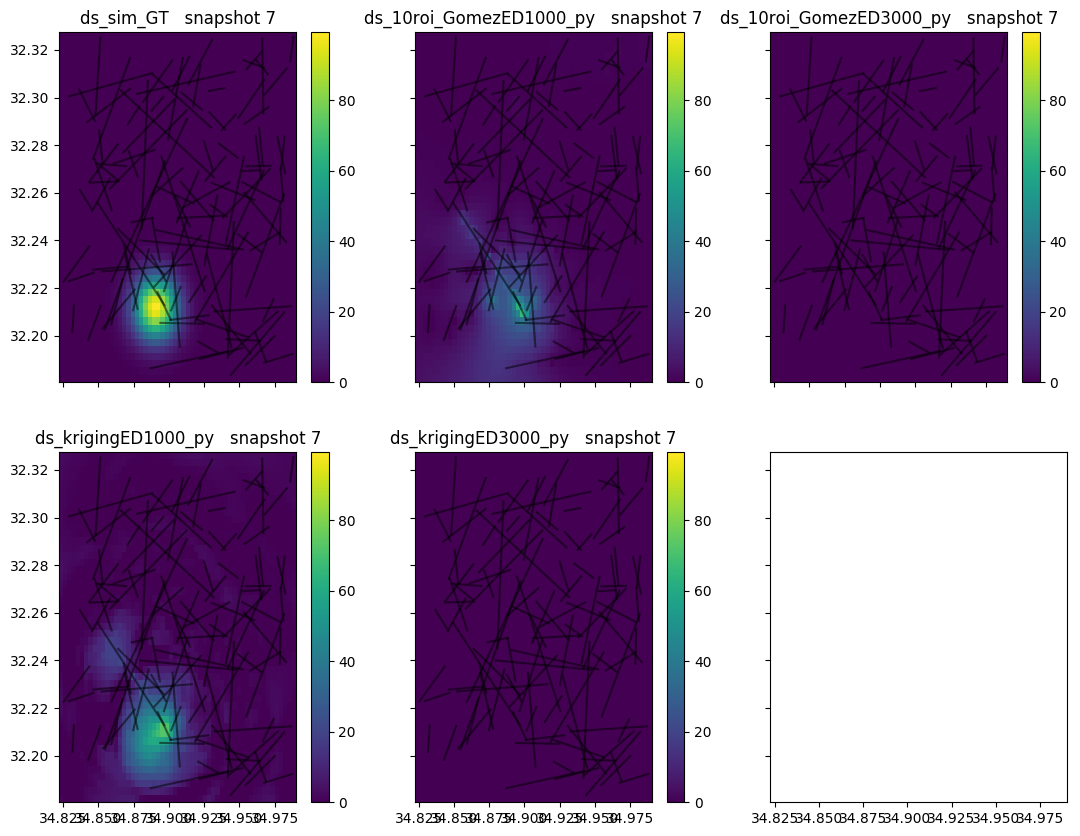

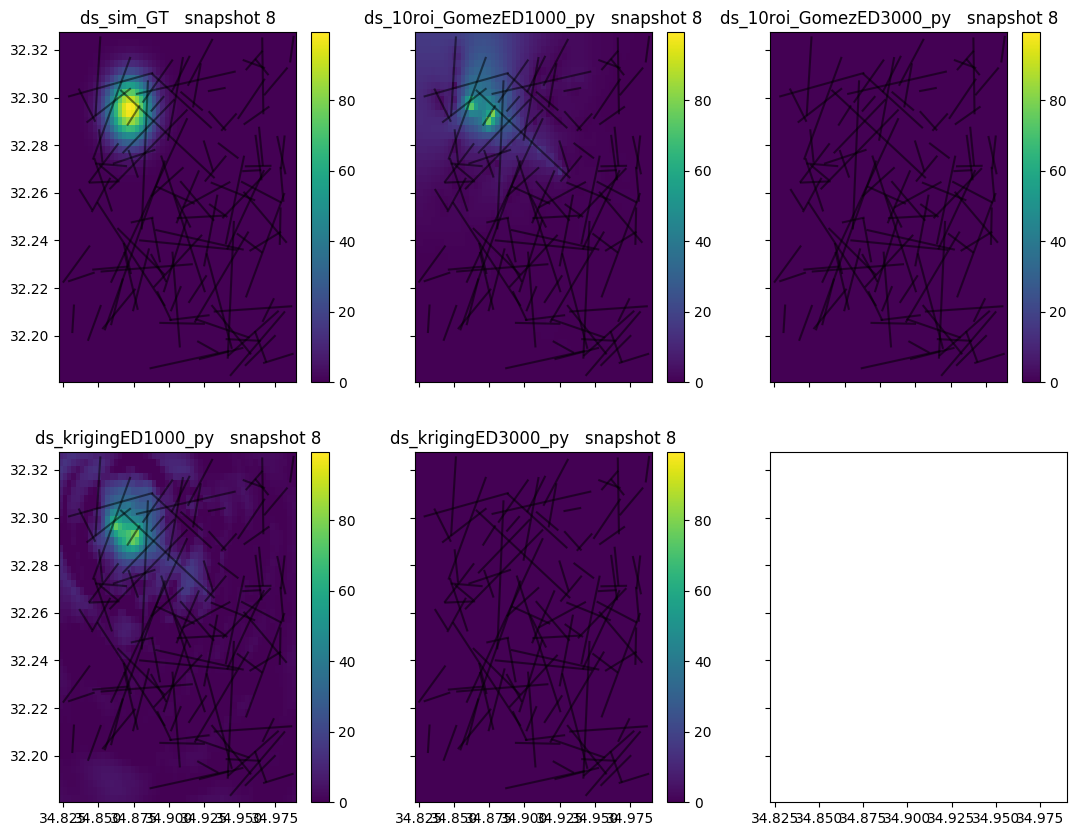

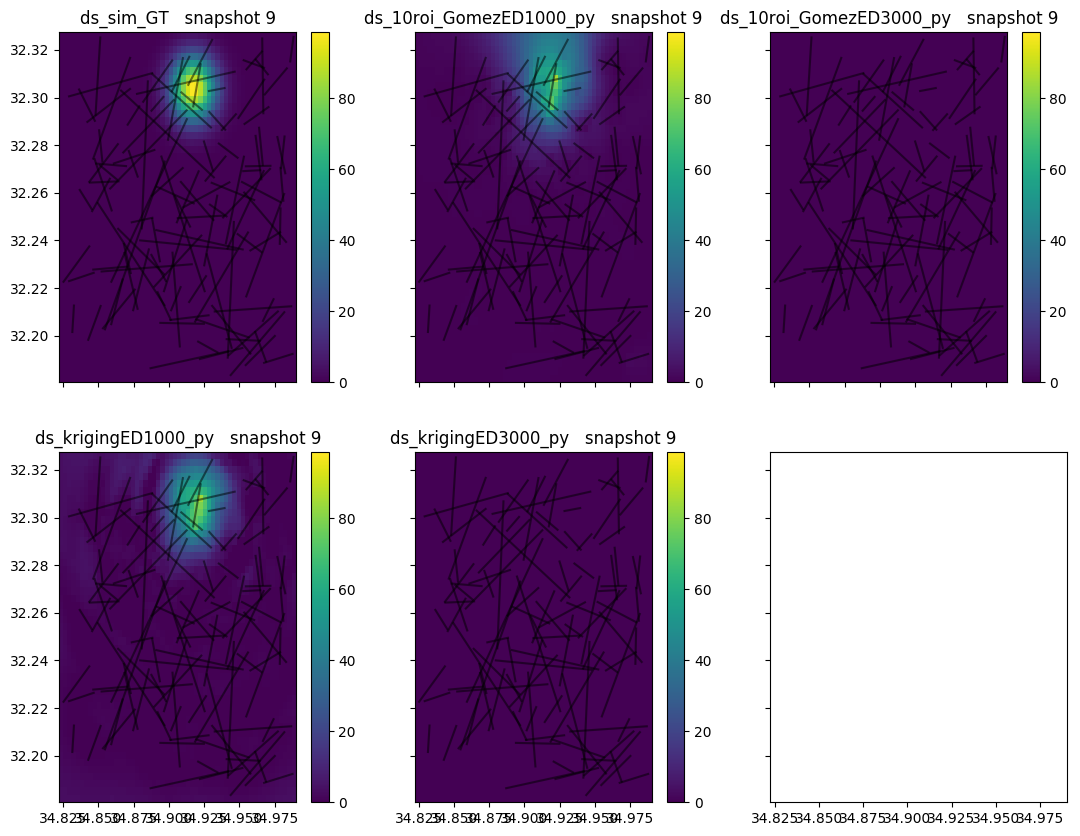

In [81]:

# Snapshots
plt.style.use('default')

i=0
for snapshot in range(len(globals()[list_of_datasets[0]]['time'])):
    if len(list_of_datasets) <= 3:
        fig, ax = plt.subplots(rows_in_fig, cols_in_fig, figsize=(10,4), sharex=True, sharey=True)
    else:
        fig, ax = plt.subplots(rows_in_fig, cols_in_fig, figsize=(13,10), sharex=True, sharey=True)
    col, row = np.meshgrid(np.arange(0, 
                                     cols_in_fig, 
                                     1), 
                           np.arange(0, 
                                     rows_in_fig, 
                                     1))

    for i in range(len(list_of_datasets)):
        if rows_in_fig < 2:
            pc = ax[col.flatten()[i]].pcolormesh(globals()[list_of_datasets[i]].lon_grid.values,
                                        globals()[list_of_datasets[i]].lat_grid.values,
                                        globals()[list_of_datasets[i]].raindepth.isel(time=snapshot,
                                                                                      link_iter=CLI),
                                                                 vmin=0,
                                                                 vmax=ds_sim_GT.raindepth[:,:,snapshot].max())
            print(len(globals()[list_of_datasets[i]].lat_grid[0]))
            line = ax[col.flatten()[i]].plot([globals()['links_MD_' + str(CLI)].lon1.values,globals()['links_MD_' + str(CLI)].lon2.values],
                    [globals()['links_MD_' + str(CLI)].lat1.values,globals()['links_MD_' + str(CLI)].lat2.values],
                    'k', alpha=0.5)
            ax[col.flatten()[i]].set_title(list_of_datasets[i] + '   snapshot ' + str(snapshot))
            plt.colorbar(pc, ax=ax[col.flatten()[i]])
            # save only the first and last pictures
            if snapshot==0 or snapshot==range(len(globals()[list_of_datasets[0]]['time']))[-1]:
                fig.savefig(sim_path + "snapshot" + str(snapshot) + "LSett" + str(CLI) + ".pdf", bbox_inches='tight')

        else:
            pc = ax[row.flatten()[i],col.flatten()[i]].pcolormesh(globals()[list_of_datasets[i]].lon_grid.values,
                                        globals()[list_of_datasets[i]].lat_grid.values,
                                        globals()[list_of_datasets[i]].raindepth.isel(time=snapshot,
                                                                                      link_iter=CLI),
                                                                 vmin=0,
                                                                 vmax=ds_sim_GT.raindepth[:,:,snapshot].max())
            print(len(globals()[list_of_datasets[i]].lat_grid[0]))
            line = ax[row.flatten()[i],col.flatten()[i]].plot([globals()['links_MD_' + str(CLI)].lon1.values,globals()['links_MD_' + str(CLI)].lon2.values],
                    [globals()['links_MD_' + str(CLI)].lat1.values,globals()['links_MD_' + str(CLI)].lat2.values],
                    'k', alpha=0.5)
            ax[row.flatten()[i],col.flatten()[i]].set_title(list_of_datasets[i] + '   snapshot ' + str(snapshot))
            plt.colorbar(pc, ax=ax[row.flatten()[i],col.flatten()[i]])
            # save only the first and last pictures
#             if snapshot==0 or snapshot==range(len(globals()[list_of_datasets[0]]['time']))[-1]:
#                 fig.savefig(sim_path + "snapshot" + str(snapshot) + "LSett" + str(CLI) + ".pdf", bbox_inches='tight')

50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50


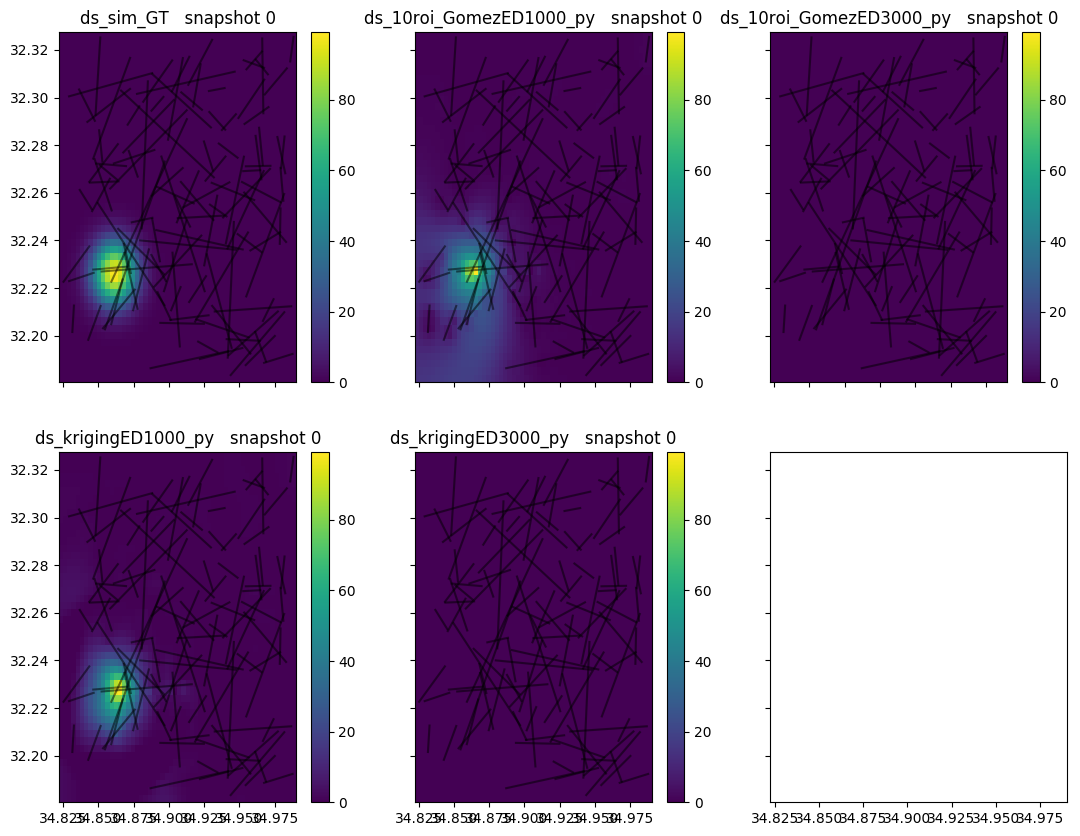

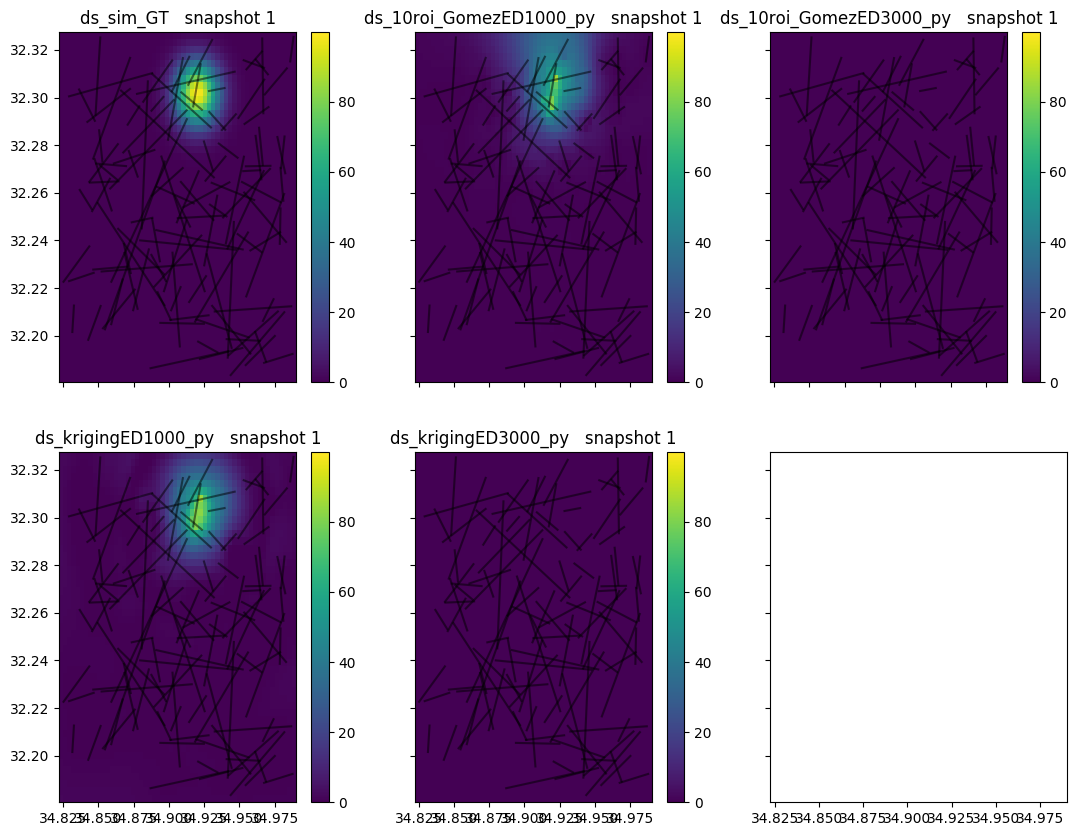

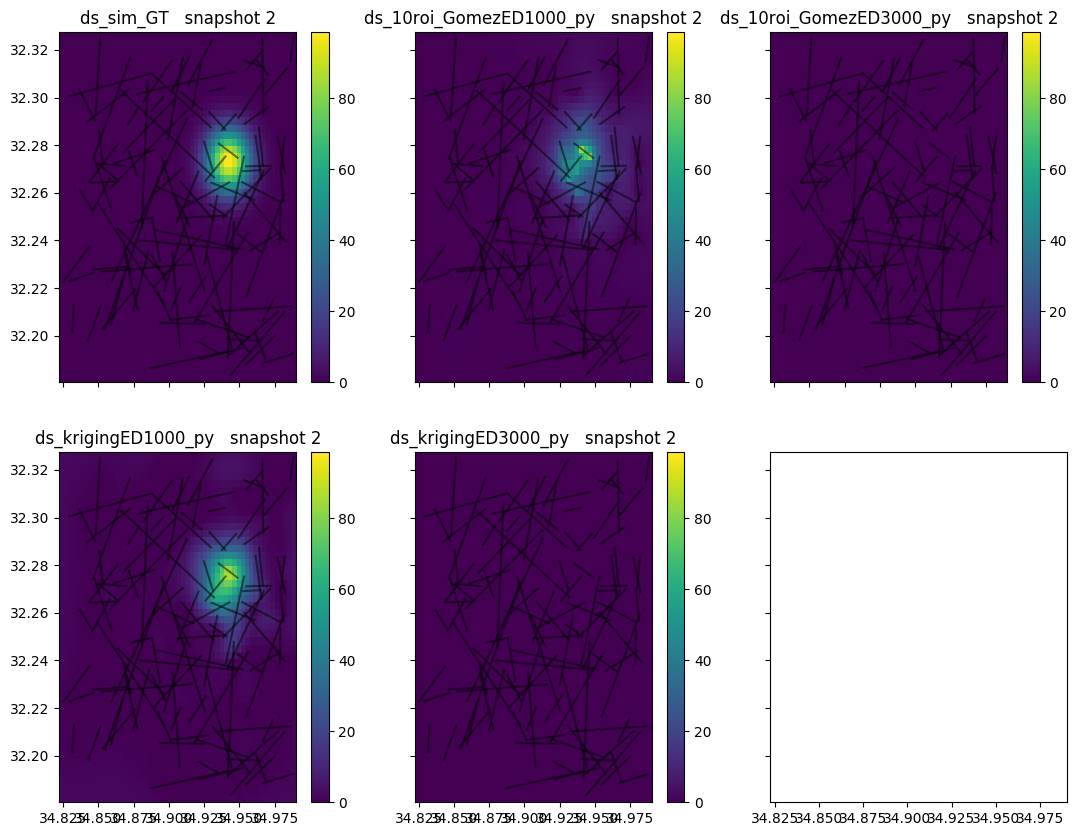

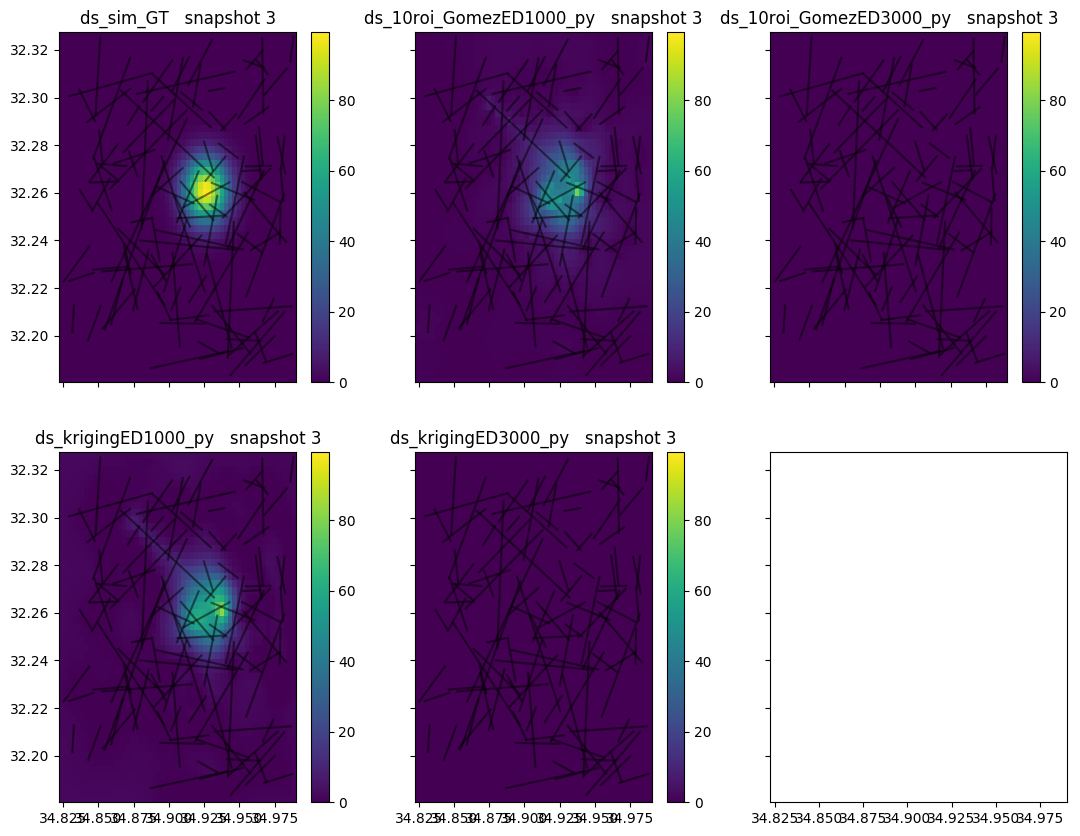

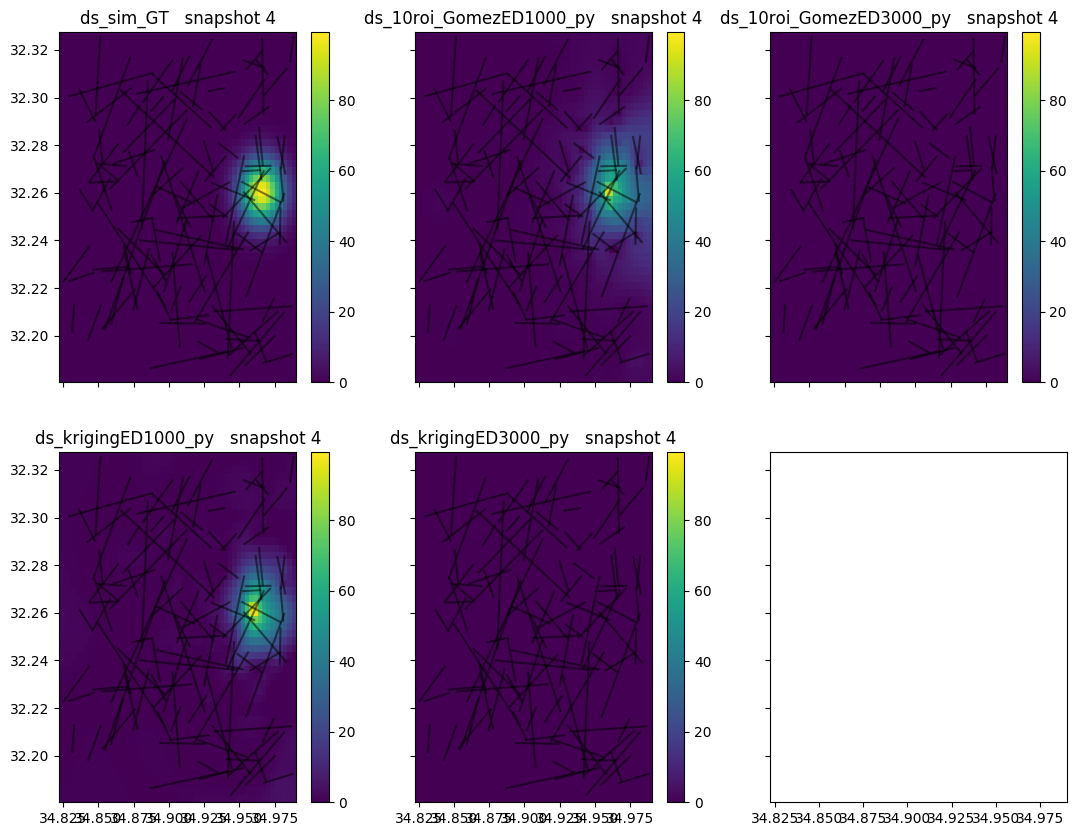

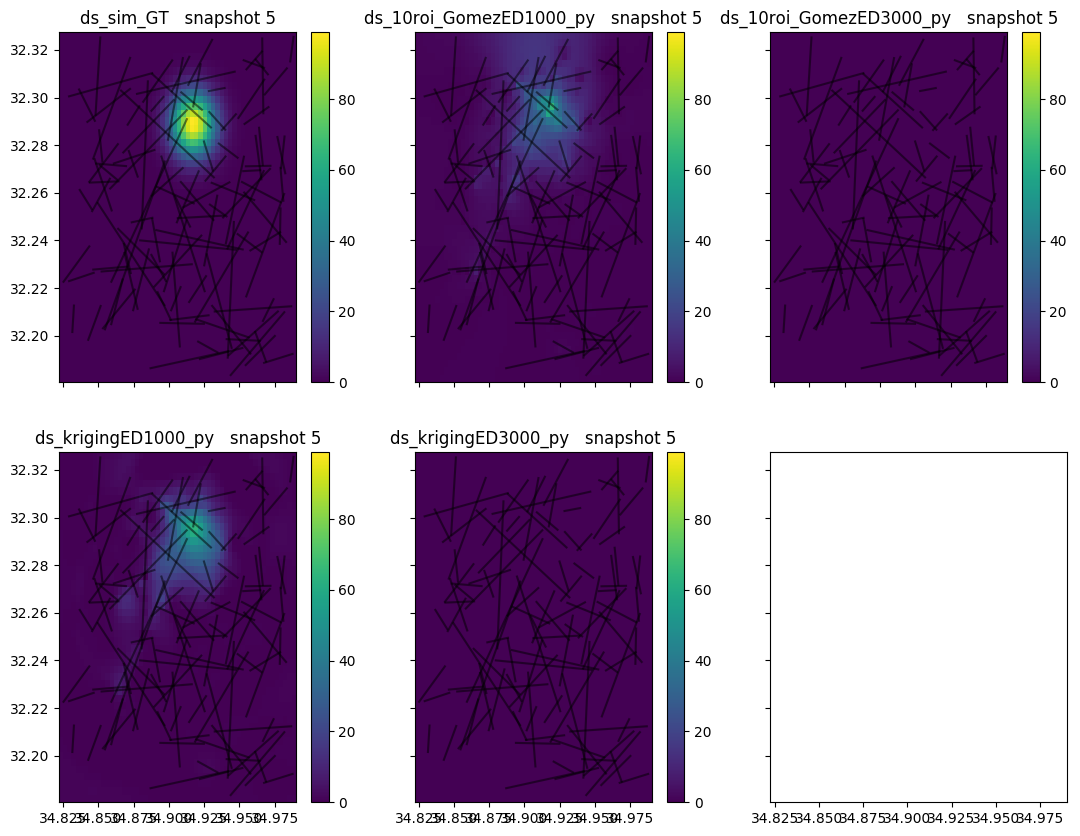

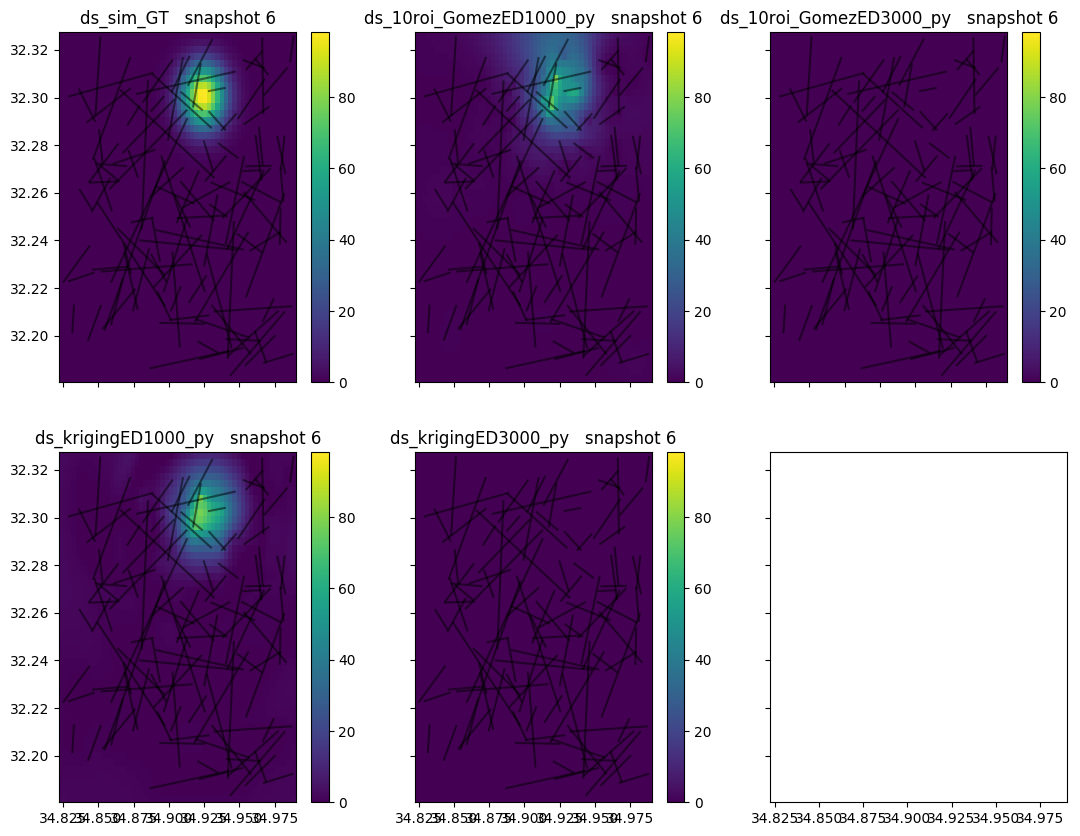

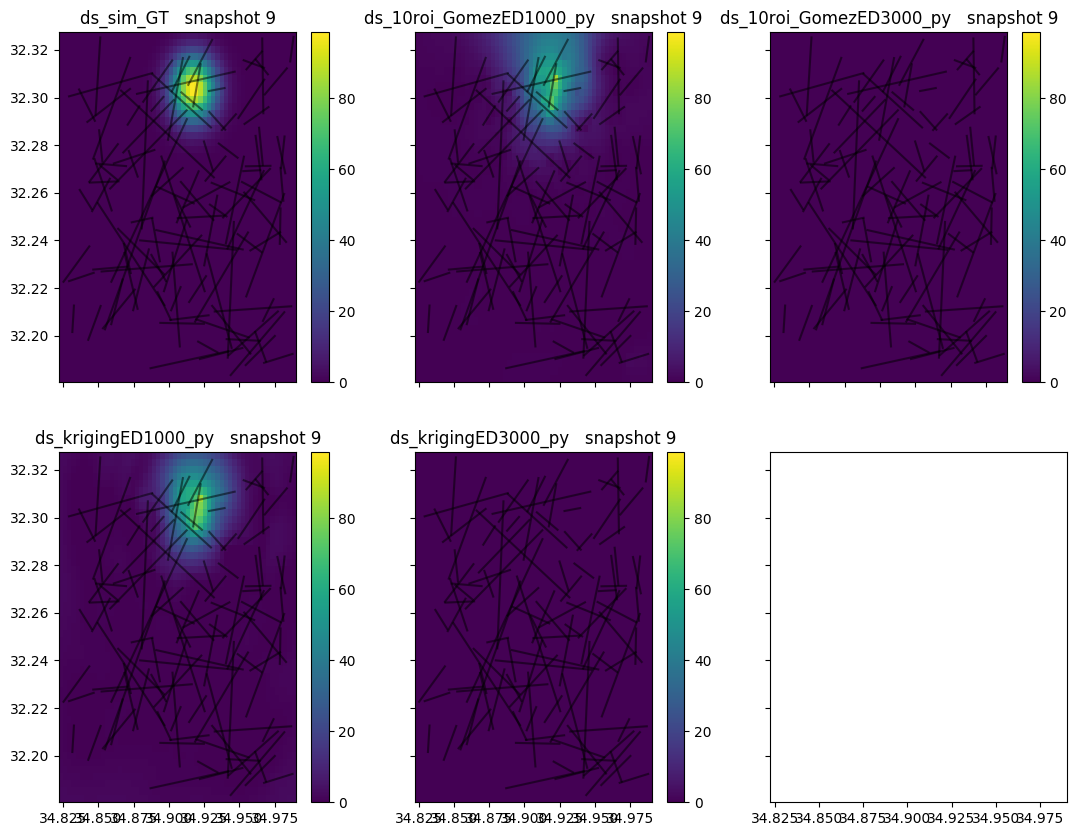

In [75]:

# Snapshots
plt.style.use('default')

i=0
for snapshot in range(len(globals()[list_of_datasets[0]]['time'])):
    if len(list_of_datasets) <= 3:
        fig, ax = plt.subplots(rows_in_fig, cols_in_fig, figsize=(10,4), sharex=True, sharey=True)
    else:
        fig, ax = plt.subplots(rows_in_fig, cols_in_fig, figsize=(13,10), sharex=True, sharey=True)
    col, row = np.meshgrid(np.arange(0, 
                                     cols_in_fig, 
                                     1), 
                           np.arange(0, 
                                     rows_in_fig, 
                                     1))

    for i in range(len(list_of_datasets)):
        if rows_in_fig < 2:
            pc = ax[col.flatten()[i]].pcolormesh(globals()[list_of_datasets[i]].lon_grid.values,
                                        globals()[list_of_datasets[i]].lat_grid.values,
                                        globals()[list_of_datasets[i]].raindepth.isel(time=snapshot,
                                                                                      link_iter=CLI),
                                                                 vmin=0,
                                                                 vmax=ds_sim_GT.raindepth[:,:,snapshot].max())
            print(len(globals()[list_of_datasets[i]].lat_grid[0]))
            line = ax[col.flatten()[i]].plot([globals()['links_MD_' + str(CLI)].lon1.values,globals()['links_MD_' + str(CLI)].lon2.values],
                    [globals()['links_MD_' + str(CLI)].lat1.values,globals()['links_MD_' + str(CLI)].lat2.values],
                    'k', alpha=0.5)
            ax[col.flatten()[i]].set_title(list_of_datasets[i] + '   snapshot ' + str(snapshot))
            plt.colorbar(pc, ax=ax[col.flatten()[i]])
            # save only the first and last pictures
            if snapshot==0 or snapshot==range(len(globals()[list_of_datasets[0]]['time']))[-1]:
                fig.savefig(sim_path + "snapshot" + str(snapshot) + "LSett" + str(CLI) + ".pdf", bbox_inches='tight')

        else:
            pc = ax[row.flatten()[i],col.flatten()[i]].pcolormesh(globals()[list_of_datasets[i]].lon_grid.values,
                                        globals()[list_of_datasets[i]].lat_grid.values,
                                        globals()[list_of_datasets[i]].raindepth.isel(time=snapshot,
                                                                                      link_iter=CLI),
                                                                 vmin=0,
                                                                 vmax=ds_sim_GT.raindepth[:,:,snapshot].max())
            print(len(globals()[list_of_datasets[i]].lat_grid[0]))
            line = ax[row.flatten()[i],col.flatten()[i]].plot([globals()['links_MD_' + str(CLI)].lon1.values,globals()['links_MD_' + str(CLI)].lon2.values],
                    [globals()['links_MD_' + str(CLI)].lat1.values,globals()['links_MD_' + str(CLI)].lat2.values],
                    'k', alpha=0.5)
            ax[row.flatten()[i],col.flatten()[i]].set_title(list_of_datasets[i] + '   snapshot ' + str(snapshot))
            plt.colorbar(pc, ax=ax[row.flatten()[i],col.flatten()[i]])
            # save only the first and last pictures
#             if snapshot==0 or snapshot==range(len(globals()[list_of_datasets[0]]['time']))[-1]:
#                 fig.savefig(sim_path + "snapshot" + str(snapshot) + "LSett" + str(CLI) + ".pdf", bbox_inches='tight')

___

# Analysis

In [63]:
from analysis_funcs import *

## Threshold for rain intensity to be used in time_corr and time_rmse funcs

In [64]:
rain_thresh = 0.0 # threshold for rain intensity to be used in time_corr and time_rmse funcs

### Correlation coeff. with GT for each timestamp

In [65]:
# # Style
# plt.style.use('seaborn-darkgrid')
# # plt.style.use('default')
# for cli in range(num_of_link_iter): # cosen link iteration in lowercase letters
#     fig, ax = plt.subplots(2, 1, figsize=(15,10), sharex=True)
#     sizes = 20

#     legend_list = []
#     for item in list_of_datasets:
#         if item == 'ds_sim_GT':
#             continue
#         myCorr = time_corr_spatSnapshots(ds_sim_GT.isel(link_iter=cli), 
#                                          globals()[item].isel(link_iter=cli),
#                                         threshold=rain_thresh)
#         ax[0].plot(globals()[item]['time'], 
#                    myCorr, 
#                    label= item,
#                    marker='o')
#         legend_list.append(item)

#     ax[1].plot(ds_sim_GT['time'],
#                 ds_sim_GT.raindepth.mean('x').mean('y'), 
#                 label='Ave. domain rain', 
#                 marker='o')

#     ax[1].set_xlabel('Time (UTC)',fontsize=sizes)
#     ax[0].set_ylabel('r',fontsize=sizes)
#     ax[1].set_ylabel('Rain intensity (mm/h)',fontsize=sizes)
#     ax[0].tick_params(labelsize=sizes)
#     ax[1].tick_params(labelsize=sizes)
#     plt.suptitle('Link Setting ' + str(cli),fontsize=sizes)

#     # # Add legend
#     ax[0].legend(fontsize=sizes/2, loc="best")
# #     ax[1].legend(fontsize=sizes/2, loc="best")
    
#     fig.savefig(sim_path + "corr" + str(cli) + ".pdf", bbox_inches='tight')



#     for item in list_of_datasets:
#         if item == 'ds_sim_GT':
#             continue
#         myCorr = time_corr_spatSnapshots(ds_sim_GT.isel(link_iter=cli), 
#                                          globals()[item].isel(link_iter=cli),
#                                         threshold=rain_thresh)
#         corrIndex=0
#         for corrIndex in range(len(myCorr)):
#             print(item + ' for timestamp_' + str(corrIndex) +\
#                   ', link_iter_' + str(cli) + ': r='  + str(round(myCorr[corrIndex],3)))
    

ds_10roi_GomezED1000_py for timestamp_0: RMSE=1.687
ds_10roi_GomezED1000_py for timestamp_1: RMSE=1.564
ds_10roi_GomezED1000_py for timestamp_2: RMSE=1.743
ds_10roi_GomezED1000_py for timestamp_3: RMSE=1.932
ds_10roi_GomezED1000_py for timestamp_4: RMSE=1.749
ds_10roi_GomezED1000_py for timestamp_5: RMSE=1.863
ds_10roi_GomezED1000_py for timestamp_6: RMSE=1.776
ds_10roi_GomezED1000_py for timestamp_7: RMSE=1.535
ds_10roi_GomezED1000_py for timestamp_8: RMSE=1.32
ds_10roi_GomezED1000_py for timestamp_9: RMSE=1.925
ds_10roi_GomezED3000_py for timestamp_0: RMSE=1.852
ds_10roi_GomezED3000_py for timestamp_1: RMSE=1.561
ds_10roi_GomezED3000_py for timestamp_2: RMSE=1.811
ds_10roi_GomezED3000_py for timestamp_3: RMSE=1.921
ds_10roi_GomezED3000_py for timestamp_4: RMSE=1.855
ds_10roi_GomezED3000_py for timestamp_5: RMSE=1.812
ds_10roi_GomezED3000_py for timestamp_6: RMSE=1.774
ds_10roi_GomezED3000_py for timestamp_7: RMSE=1.557
ds_10roi_GomezED3000_py for timestamp_8: RMSE=1.229
ds_10roi_Gome

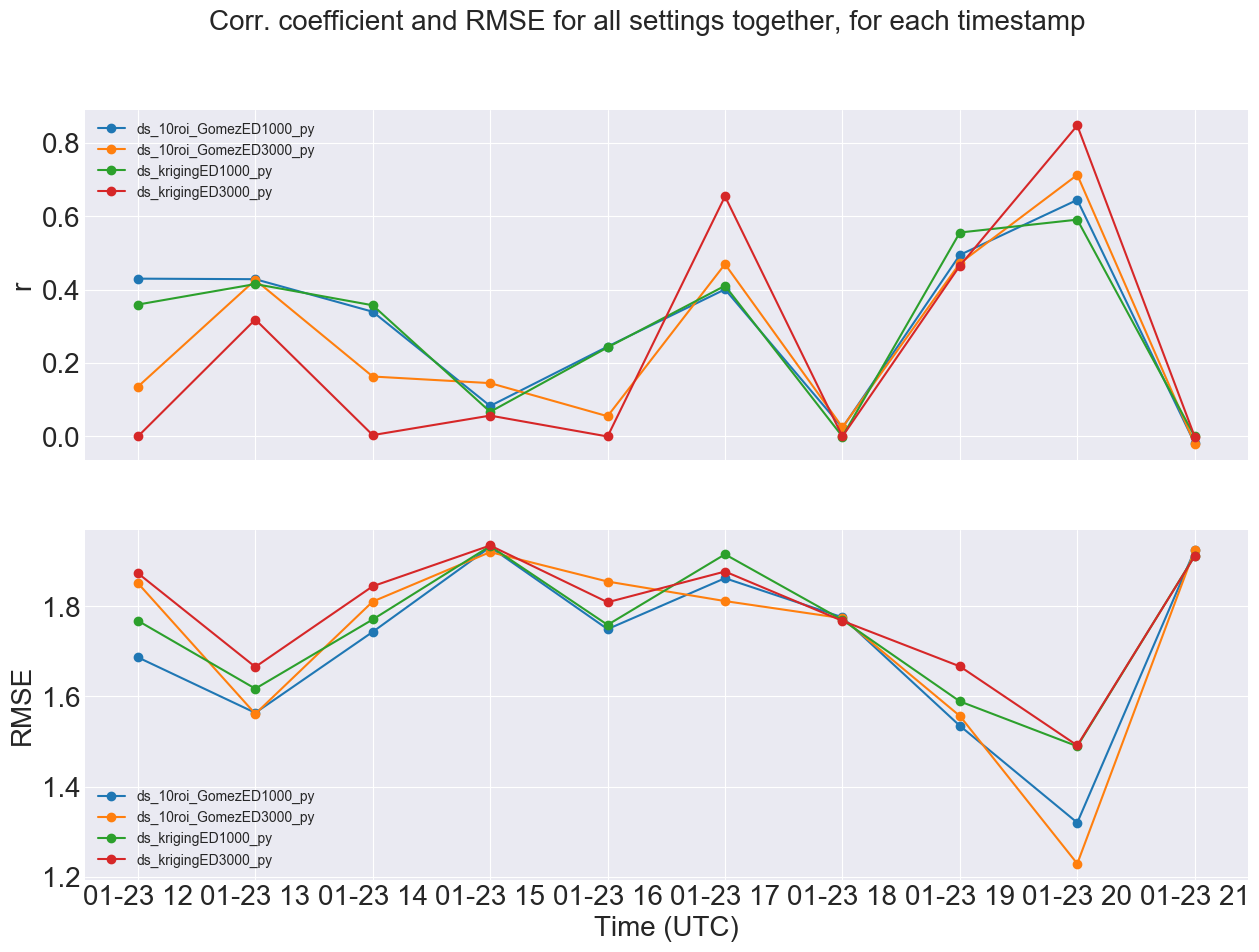

In [66]:
# Style
plt.style.use('seaborn-darkgrid')
# plt.style.use('default')
fig, ax = plt.subplots(2, 1, figsize=(15,10), sharex=True)
sizes = 20

legend_list = []
for item in list_of_datasets:
    if item == 'ds_sim_GT' or 'IE' in item:
        continue
    myCorr = time_corr_spatSnapshots(ds_sim_GT, globals()[item], threshold=rain_thresh)
    ax[0].plot(globals()[item]['time'], 
                myCorr, 
                label= item,
                marker='o')
    legend_list.append(item)
        
    myRMSE = time_RMSE_spatSnapshots(ds_sim_GT, globals()[item], threshold=rain_thresh)
#     print(myRMSE)
    ax[1].plot(globals()[item]['time'], 
                myRMSE, 
                label= item,
                marker='o')
    legend_list.append(item)

ax[1].set_xlabel('Time (UTC)',fontsize=sizes)
ax[0].set_ylabel('r',fontsize=sizes)
ax[1].set_ylabel('RMSE',fontsize=sizes)
ax[0].tick_params(labelsize=sizes)
ax[1].tick_params(labelsize=sizes)
plt.suptitle('Corr. coefficient and RMSE for all settings together, for each timestamp', fontsize=sizes)

    # # Add legend
ax[0].legend(fontsize=sizes/2, loc="best")
ax[1].legend(fontsize=sizes/2, loc="best")


# fig.savefig(sim_path + "corr_rmse.pdf", bbox_inches='tight')
for item in list_of_datasets:
    if item == 'ds_sim_GT':
        continue
    myRMSE = time_RMSE_spatSnapshots(ds_sim_GT, globals()[item], threshold=rain_thresh)
    RMSEIndex=0
    for RMSEIndex in range(len(myRMSE)):
        print(item + ' for timestamp_' + str(RMSEIndex) +\
              ': RMSE='  + str(round(myRMSE[RMSEIndex],3)))



### Corr RMSE with fixed scale 

In [67]:
rain_thresh = 0.0


In [68]:
# # Style
# plt.style.use('seaborn-darkgrid')
# # plt.style.use('default')
# fig, ax = plt.subplots(2, 1, figsize=(15,10), sharex=True)
# sizes = 20

# legend_list = []
# for item in list_of_datasets:
#     if item == 'ds_sim_GT' or 'IE' in item:
#         continue
#     myCorr = time_corr_spatSnapshots(ds_sim_GT, 
#                                      globals()[item], 
#                                      threshold=rain_thresh, 
#                                      rounding=True,
#                                      equal_to_thresh=False)
#     ax[0].plot(globals()[item]['time'], 
#                 myCorr, 
#                 label= item,
#                 marker='o')
#     legend_list.append(item)
        
#     myRMSE = time_RMSE_spatSnapshots(ds_sim_GT, 
#                                      globals()[item], 
#                                      threshold=rain_thresh, 
#                                      rounding=True)
# #     print(myRMSE)
#     ax[1].plot(globals()[item]['time'], 
#                 myRMSE, 
#                 label= item,
#                 marker='o')
#     legend_list.append(item)

# ax[1].set_xlabel('Time (UTC)',fontsize=sizes)
# ax[0].set_ylabel('r',fontsize=sizes)
# ax[1].set_ylabel('RMSE',fontsize=sizes)
# ax[0].tick_params(labelsize=sizes)
# ax[1].tick_params(labelsize=sizes)


# f = open(sim_path + "/list_of_runParam.txt", "r")
# for line in f:
#     if 'std_max:' in line:
#         std_rainCell = float(line.split()[-2])
#         break
# f.close() 
# del f
# plt.suptitle('std rain cell = ' + str(std_rainCell) + ' m',fontsize=sizes)
    
# # plt.suptitle('Corr. coefficient and RMSE for all settings together, for each timestamp', fontsize=sizes)

# ylim_top = 10.5
# ylim_bot = 2
# # ax[1].set_ylim([ylim_bot,ylim_top])
# # ax[1].yticks(np.arange(ylim_bot, ylim_top, step=1.0))

# ylim_top = 1
# ylim_bot = 0.5
# ax[0].set_ylim([ylim_bot,ylim_top])



#     # # Add legend
# ax[0].legend(fontsize=sizes/2, loc="lower left")
# ax[1].legend(fontsize=sizes/2, loc="lower left")


# # fig.savefig(sim_path + "corr_rmse_fixed.pdf", bbox_inches='tight')
# for item in list_of_datasets:
#     if item == 'ds_sim_GT':
#         continue
#     myRMSE = time_RMSE_spatSnapshots(ds_sim_GT, globals()[item], threshold=rain_thresh, rounding=True)
# #     RMSEIndex=0
#     for RMSEIndex in range(len(myRMSE)):
#         print(item + ' for timestamp_' + str(RMSEIndex) +\
#               ': RMSE='  + str(round(myRMSE[RMSEIndex],3)))



In [69]:
# # scatter plots
# from scipy import stats
# from scipy.optimize import curve_fit

# def func(x, a):
#     return a * x

# for cli in range(num_of_link_iter): # cosen link iteration in lowercase letters
#     fig, ax = plt.subplots(rows_in_fig, cols_in_fig, figsize=(13,10), sharex=True, sharey=True)
#     col, row = np.meshgrid(np.arange(0, 
#                                      cols_in_fig, 
#                                      1), 
#                            np.arange(0, 
#                                      rows_in_fig, 
#                                      1))
    
#     fig.text(0.5, 0.04, 'Ground truth (mm h$^{-1}$)', ha='center', fontsize=sizes) # x axis
#     fig.text(0.04, 0.5, 'Reconstruction (mm h$^{-1}$)', va='center', rotation='vertical', fontsize=sizes) # y axi

#     for i in range(len(list_of_datasets)):
#         grayscale = np.linspace(180, 
#                                 10, 
#                                 len(globals()[list_of_datasets[0]]['time']))/255

#         for snapshot in range(len(globals()[list_of_datasets[0]]['time'])):
#     ##############################################################
#     ######### Create a darker scatter for each timestamp #########
#     ##############################################################
#             sp = ax[row.flatten()[i],
#                     col.flatten()[i]].scatter(ds_sim_GT.raindepth[:,:,snapshot,cli], 
#                                               globals()[list_of_datasets[i]].raindepth[:,:,snapshot,cli],
#                                               s=9,
#                                               c=str(grayscale[snapshot]),
#                                               label='Timestamp ' + str(snapshot))
#         # get rid of nans
#         nan_pairs = ~np.logical_or(np.isnan(ds_sim_GT.raindepth.values[:,:,:,cli].flatten()), 
#                                    np.isnan(globals()[list_of_datasets[i]].raindepth.values[:,:,:,cli].flatten())) 

#         obs1 = np.compress(nan_pairs,
#                           ds_sim_GT.raindepth.values[:,:,:,cli].flatten())
#         reconstruction1 = np.compress(nan_pairs,
#                                      globals()[list_of_datasets[i]].raindepth.values[:,:,:,cli].flatten())
        
#                 ################
#         # get rid of values smaller than Threshold for the correlation
#         pairs = ~np.logical_and(obs1 < rain_thresh,
#                                 reconstruction1 < rain_thresh) 

#         obs = np.compress(pairs, obs1)
#         reconstruction = np.compress(pairs, reconstruction1)
#         ################
        
#         # linear regression
#         popt, pcov = curve_fit(func, obs, reconstruction)
#         residuals = reconstruction - func(obs, *popt)
#         ss_res = np.sum(residuals**2)
#         ss_tot = np.sum((reconstruction-np.mean(reconstruction))**2)
#         r_squared = 1 - (ss_res / ss_tot)
# #         slope, intercept, r_value, p_value, std_err = stats.linregress(obs, 
# #                                                                      reconstruction)
# #         del slope, intercept, p_value, std_err
        
#         line = ax[row.flatten()[i],
#                     col.flatten()[i]].plot(obs, 
#                                            func(obs, *popt), 
#                                            'r', 
#                                            label='fit: slope=%5.3f' % tuple(popt))


#         ax[row.flatten()[i],col.flatten()[i]].set_title(list_of_datasets[i] + '   \
#         $r^2$=' + str(round(float(r_squared),3)))
# #         ax[row.flatten()[i],col.flatten()[i]].legend()
#     f = open(sim_path + "/list_of_runParam.txt", "r")
#     for line in f:
#         if 'std_max:' in line:
#             std_rainCell = float(line.split()[-2])
#             break
#     f.close() 
#     del f
# #     plt.suptitle('Link Setting ' + str(cli),fontsize=sizes)
#     plt.suptitle('std rain cell = ' + str(std_rainCell) + ' m',fontsize=sizes)
# #     fig.savefig(sim_path + "lin_regress" + str(cli) + ".jpg", bbox_inches='tight')



In [70]:
import dill
# dill.dump_session(sim_path + 'Sim_analysis.db')
# dill.dump_session(sim_path + 'Sim_analysis_krg9.db')
# dill.load_session(sim_path + 'Sim_analysis13.db')
# dill.dump_session(sim_path + 'Sim_analysis_krg3.db')
dill.dump_session(sim_path + 'Sim_analysis_ED.db')

from IPython.display import Audio
sound_file = '/Users/adameshel/Documents/Python_scripts/beep-01a.wav'
Audio(sound_file, autoplay=True)

# Load a saved session

In [1]:
import datetime
now = datetime.datetime.now()
sim_path = '/Volumes/0543970348/IE_directory/simulation/synthetic_lior/small12/'

%matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import numpy as np
import xarray as xr
import pandas as pd
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import os.path
import glob
# from os import listdir
from pyproj import Proj, transform
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import curve_fit

import sys
# the equivalent to "Add to path" in Matlab
sys.path.append("/Users/adameshel/Documents/Python_scripts/wrf_hydro_pyscripts/") 
from helper_functions import matlab2datetime as matlab2datetime_fancy_import
from helper_functions import split_at

from os.path import isfile, join

import sys
sys.path.append("../my_fuctions/") # the equivalent to "Add to path" in Matlab

# from iterative_IDW import * # Old code (Daniel's)
from iterative_IDW_V1 import *

from geoFunc import *
import kriging as krg

import dill

dill.load_session(sim_path + 'Sim_analysis_krg9.db')

from analysis_funcs import *

AttributeError: 'Variable' object has no attribute '__dict__'

In [ ]:
from IPython.display import Audio
sound_file = '/Users/adameshel/Documents/Python_scripts/beep-01a.wav'
Audio(sound_file, autoplay=True)


### Differences in rain intensities

In [40]:
# vectorizing a function which suits scalars
relative_diff_f=np.vectorize(relative_diff)
spat_rmse_matIDW = relative_diff_f(ds_sim_GT['raindepth'].isel(time=-1, link_iter=CLI).values,
                                   ds_6roi_IDW1['raindepth'].values[:,:,-1,CLI])

spat_rmse_matGOMEZ = relative_diff_f(ds_sim_GT['raindepth'].isel(time=-1, link_iter=CLI).values,
                                   ds_6roi_Gomez3['raindepth'].values[:,:,-1,CLI])


NameError: name 'ds_6roi_IDW1' is not defined

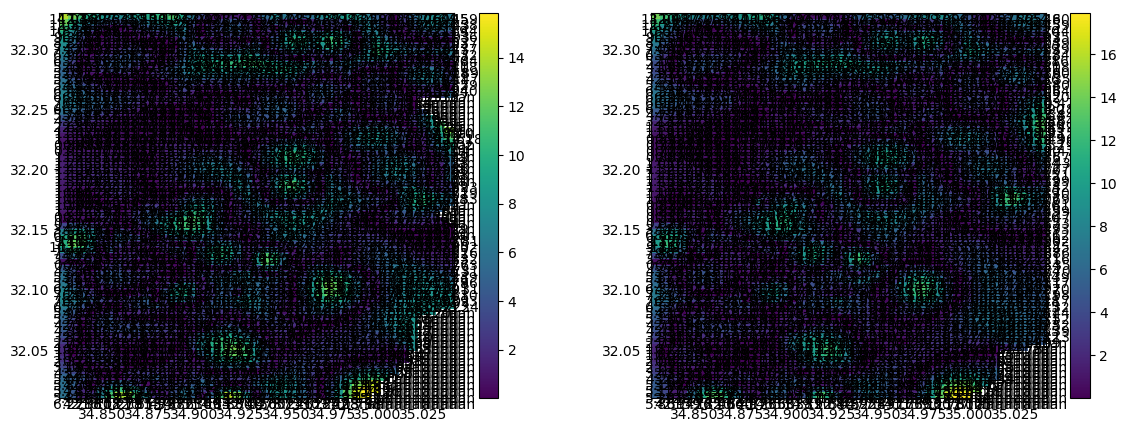

In [20]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
pc = ax[0].pcolormesh(xgrid,ygrid,spat_rmse_matIDW)
plt.colorbar(ax = ax[0], mappable=pc)

for y in range(ygrid[0,:].shape[0]):
    for x in range(xgrid[:,0].shape[0]):
        ax[0].text(xgrid[x,0] + 0.005, ygrid[0,y] - 0.005, '%.2f' % spat_rmse_matIDW[x, y],
                 horizontalalignment='center',
                 verticalalignment='center')
        
        
pc = ax[1].pcolormesh(xgrid,ygrid,spat_rmse_matGOMEZ)
plt.colorbar(ax = ax[1], mappable=pc)

for y in range(ygrid[0,:].shape[0]):
    for x in range(xgrid[:,0].shape[0]):
        ax[1].text(xgrid[x,0] + 0.005, ygrid[0,y] - 0.005, '%.2f' % spat_rmse_matGOMEZ[x, y],
                 horizontalalignment='center',
                 verticalalignment='center')

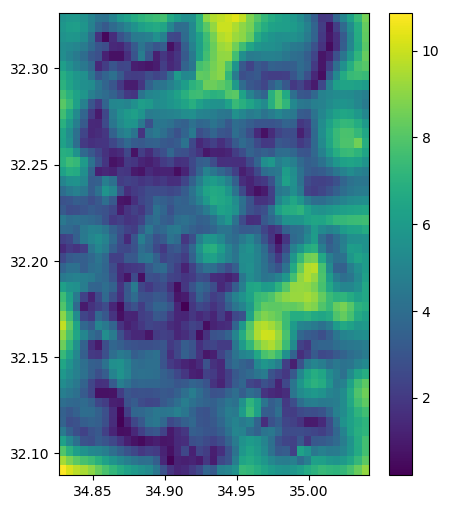

In [18]:
# Spatial rmse plot... If needed
fig, ax = plt.subplots(figsize=(5,6))
pc = ax.pcolormesh(xgrid,ygrid,spatialRMSE(ds_sim_GT.isel(link_iter=CLI),ds_30roi_Gomez3.isel(link_iter=CLI)))
plt.colorbar(pc)

(array([    0.,     0.,     0.,     0.,     0., 17856.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

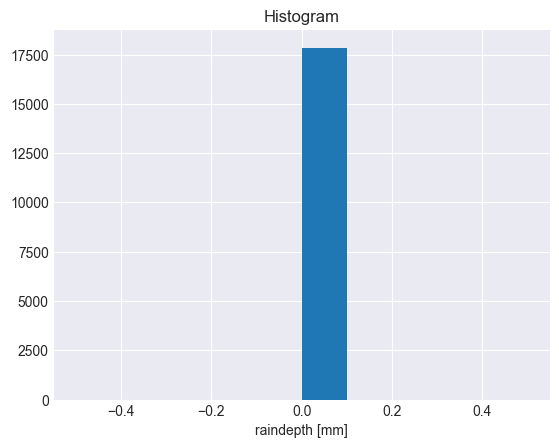

In [46]:
ds_kriging1_py.raindepth.sel(link_iter=3).plot()
